# specific events

general comparison of:

* london (lon2) internet data use
* london (m road/ mainly m25) road traffic counts
* england/wales power demand from national grid

each from 2016-2019.
5 minute, 15 minute, 30 minute intervals respectively.

## auxiliary

just some bits and pieces that we'll need later on.

In [2]:
# consistent theme
line.colour <- "#8b0000" # dark red
model.colour <- "#777777" # grey

In [3]:
plot_model <- function(ts, y.name, from, to, daily=F, ...) {
    ts.range <- ts[ts$date >= from & ts$date <= to, ]
    dates <- strftime(unique(ts.range$date), "%d-%m-%y")
    date.idx <- which(!duplicated(ts.range$date)) # first occurrance of date.
    if(nrow(ts.range) == 0) {
        plot.new()
    } else {
        if(daily) {
            # mean by day of year
            #series <- tapply(ts.range[, y.name], strftime(ts.range$date, format = "%j"), mean)
            #model <- tapply(ts.range$model, strftime(ts.range$date, format = "%j"), mean)
            series <- tapply(ts.range[, y.name], as.Date(ts.range$date, tz="UTC"), mean)
            model <- tapply(ts.range$model, as.Date(ts.range$date, tz="UTC"), mean)
        } else {
            series <- ts.range[, y.name]
            model <- ts.range$model
        }
        plot(series, type="l", col=line.colour, cex.lab=0.8, axes=F, ...)
        axis(1, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=2, at=date.idx, labels=dates)
        axis(2, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1)
        lines(model, col=model.colour)
    }
}

plot_res <- function(ts, y.name, from, to, daily=F, model="model", quant=NULL, ...) {
    ts.range <- ts[ts$date >= from & ts$date <= to, ]
    if(nrow(ts.range) == 0) {
        plot.new()
    } else {
        if(daily) {
            res <- tapply(ts.range[, y.name] - ts.range[, model], as.Date(ts.range$date, tz="UTC"), mean)
        } else {
            res <- ts.range[, y.name] - ts.range[, model]
        }
        plot(res, type="h", ...)
    }
    if(length(quant) > 0) {
        abline(h=quants, col="red", lty=2)
    }
}

plot_event_closeup <- function(date.from, date.to, daily=F) {
    options(repr.plot.width=10, repr.plot.height=6)
    par(mfrow=c(2, 3), bty="n")
    
    plot_model(internet.daily, "bw", date.from, date.to, daily, ylab="internet traffic")
    plot_model(road.daily, "count_median", date.from, date.to, daily, ylab="road traffic")
    plot_model(power.daily, "ENGLAND_WALES_DEMAND", date.from, date.to, daily, ylab="power demand")
    
    plot_res(internet.daily, "bw", date.from, date.to, daily, ylab="internet traffic", quant=quants)
    plot_res(road.daily, "count_median", date.from, date.to, daily, ylab="road traffic")
    plot_res(power.daily, "ENGLAND_WALES_DEMAND", date.from, date.to, daily, ylab="power demand")
    
    #plot_res(internet.daily, "bw", date.from, date.to, daily, model="mean_model", ylab="internet traffic")
    #plot_res(road.daily, "count_median", date.from, date.to, daily, model="mean_model", ylab="road traffic")
    #plot_res(power.daily, "ENGLAND_WALES_DEMAND", date.from, date.to, daily, model="mean_model", ylab="power demand")
}

In [4]:
# apply fun over a rolling window of x.
# window = vector of -N indices to include in the window
#  (this allows things like "every other" or "last 1, 10, 20")
# fun = function to apply to moving window.
wapply <- function(x, window=1:10, fun=mean) {

    res <- rep(NA, length(x))
    names(res) <- names(x)
    
    i <- max(window) + 1
    
    while(i <= length(x)) { 
    
        res[i] <- fun(x[i - window])
        i <- i + 1
    }
    res
}
#x <- 1:10
#names(x) <- c(rep(c("a", "b", "c"), 3), "a")
#wapply(x, c(3, 6))

## load data

* data has been cleaned, pre-processed and seasonally adjusted.
* ssa has been used to seasonally adjust and create model to derive residuals for each series.

In [5]:
internet.daily <- read.csv("../../data/lon2_2016-2018_season_adjust.csv.xz", stringsAsFactors=F)
internet.daily.features <- read.csv("../../traffic_comp/bandwidth_features_london.csv", stringsAsFactors=F)

In [6]:
# bits per second -> gigabits per second.
internet.daily$bw <- internet.daily$bw * 10^-9
internet.daily$sa <- internet.daily$sa * 10^-9
internet.daily$model <- internet.daily$model * 10^-9
internet.daily$trend <- internet.daily$trend * 10^-9
internet.daily$winter_summer <- internet.daily$winter_summer * 10^-9
internet.daily$inter_week_midweek_peak <- internet.daily$inter_week_midweek_peak * 10^-9
internet.daily$day_main <- internet.daily$day_main * 10^-9
internet.daily$day_evening <- internet.daily$day_evening * 10^-9
internet.daily$day_lunch <- internet.daily$day_lunch * 10^-9
internet.daily$day_evening_2 <- internet.daily$day_evening_2 * 10^-9
internet.daily$day_commute <- internet.daily$day_commute * 10^-9

head(internet.daily)
tail(internet.daily.features)

X date       day    msm bw       month sa        model    trend   
1 1 2016-01-01 Friday  0  275.0423 1     -46.04233 279.0845 321.9008
2 2 2016-01-01 Friday  5  277.2588 1     -43.78077 273.2887 321.9011
3 3 2016-01-01 Friday 10  273.6135 1     -47.38077 267.5506 321.9013
4 4 2016-01-01 Friday 15  275.2780 1     -45.67071 261.8814 321.9015
5 5 2016-01-01 Friday 20  277.5121 1     -43.39093 256.2907 321.9017
6 6 2016-01-01 Friday 25  276.3142 1     -44.54276 250.7878 321.9019
  winter_summer inter_week_midweek_peak day_main  day_evening day_lunch
1 -4.118290     3.302134                -46.54864 26.51557     -9.69149
2 -4.111040     3.249550                -49.44137 24.39562    -10.43433
3 -4.103952     3.196875                -52.31059 22.22916    -11.09789
4 -4.096924     3.144141                -55.15493 20.02033    -11.67711
5 -4.090046     3.091332                -57.97308 17.77331    -12.16762
6 -4.083373     3.038443                -60.76369 15.49236    -12.56569
  day_evening_2 day_commute
1 -2.432339     -15.74620  
2 -2.205043     -16.00788  
3 -1.976337     -16.26890  
4 -1.746329     -16.52882  
5 -1.515178     -16.78759  
6 -1.283034     -17.04504

X          raw.changepoint1 raw.changepoint2 raw.changepoint3
1091 2018-12-26 64               197              217             
1092 2018-12-27 63               191              222             
1093 2018-12-28 63               198              219             
1094 2018-12-29 63                NA               NA             
1095 2018-12-30 64               217              233             
1096 2018-12-31 62                NA               NA             
     raw.changepoint4 raw.value1   raw.value2   raw.value3   raw.value4  
1091 247              182182707347 507611795708 477098868637 501231744635
1092 253              192787278577 498736416478 490077864224 509819923145
1093 255              182954341881 491969231581 491160751916 505937510327
1094 227              191466161140           NA           NA 534319097788
1095 245              194063030778 509553231460 498271143298 508769846047
1096 187              202759562791           NA           NA 472057784271
     raw.Min.     ⋯ mean.fixed.work.sa4 mean.commute.res mean.commute.abs.diff
1091 182182707347 ⋯ 393857423870         -94682766502    4370657862           
1092 186790859279 ⋯ 438962646950         -87242977589    3294109032           
1093 180268206995 ⋯ 428757041922         -66299108390    2598510534           
1094 188741858462 ⋯ 392332432314         -11834692087    3652106642           
1095 193497469834 ⋯ 389247281876         -38187241551    2637894707           
1096 190087583916 ⋯ 429429976117        -102166726655    4892588837           
     work.commute.res.diff work.day.len day.len les.time.len work.com.low.len
1091  15485222147          133          183     50           20              
1092   2265014944          130          190     60           27              
1093   5679373081          141          193     52           13              
1094  13663085291           NA          164     NA           NA              
1095  -9285515338          153          181     28           16              
1096 -42113149350           NA          123     NA           NA              
     work.day.width commute.depth
1091 325429088361   27322901534  
1092 305949137901   14200305588  
1093 309014889700    7792619038  
1094           NA            NA  
1095 315490200682   10890395456  
1096           NA            NA

note that road data for november and december has been removed due to midas network dropouts during that period.

In [7]:
road.daily <- read.csv("../../traffic_comp/count_median_sa_2016-2018.csv.xz", stringsAsFactors=F)
road.daily.features <- read.csv("../../traffic_comp/sa_road_features_london.csv", stringsAsFactors=F)

In [8]:
tail(road.daily)
tail(road.daily.features)

date       day       month   interval msm  count_median sa       
99355 2018-10-31 Wednesday October 91       1365 226          -260.1011
99356 2018-10-31 Wednesday October 92       1380 205          -281.2514
99357 2018-10-31 Wednesday October 93       1395 184          -302.4070
99358 2018-10-31 Wednesday October 94       1410 169          -317.5674
99359 2018-10-31 Wednesday October 95       1425 141          -345.7316
99360 2018-10-31 Wednesday October 96       1440 125          -361.8995
      model    trend   
99355 226.9825 515.4463
99356 211.8485 515.4245
99357 195.7257 515.4047
99358 178.9224 515.3868
99359 162.0180 515.3703
99360 145.7517 515.3550

count.median.sa.cp1 count.median.sa.cp2 count.median.sa.cp3
1030 12                  30                  37                 
1031 12                  48                  57                 
1032 13                  47                  58                 
1033 12                  30                  51                 
1034 12                  31                  49                 
1035 11                  31                  48                 
     count.median.sa.cp4 count.median.sa.cp5 count.median.sa.cp.val1
1030 67                  84                  -477.4458              
1031 66                  75                  -490.5571              
1032 69                  59                  -490.7445              
1033 69                  52                  -485.2989              
1034 69                  78                  -466.6187              
1035 69                  49                  -451.0874              
     count.median.sa.cp.val2 count.median.sa.cp.val3 count.median.sa.cp.val4
1030 167.9440                 35.31295               298.2943               
1031 390.1272                246.59925               364.3124               
1032 379.0121                344.86908               413.5120               
1033 211.3657                 90.23356               304.1459               
1034 296.1067                 66.76210               356.9175               
1035 306.0477                 98.14957               335.5162               
     count.mean.sa.cp.val1 ⋯ count.median.sa.mean count.median.res.mean
1030 -481.7626             ⋯ -18.16624            -21.261028           
1031 -468.1360             ⋯ -18.47382            -30.155798           
1032 -463.7329             ⋯ -13.60639             -9.097116           
1033 -479.8137             ⋯ -44.34231            -21.976262           
1034 -491.5640             ⋯ -27.95430            -33.695069           
1035 -492.0754             ⋯ -18.37900            -11.300922           
     count.kurtosis.res.mean speed.median.sa.range speed.median_sa.mean
1030 -0.096766341            12.717083             -1.84970771         
1031 -0.029654513             5.419415              0.27392482         
1032  0.134970497            11.376149              0.23026453         
1033  0.164029017             9.830520             -1.03780328         
1034 -0.005081217             9.755921             -0.04518146         
1035  0.232541251             8.997217              0.69836013         
     speed.median.res.mean speed.skewness.res.mean date       day       month  
1030 -1.50800678            0.327115162            2018-10-26 Friday    October
1031  0.18566474           -0.348703558            2018-10-27 Saturday  October
1032  0.04231322           -0.420229381            2018-10-28 Sunday    October
1033 -0.99212446           -0.056631622            2018-10-29 Monday    October
1034 -0.41029362           -0.002082751            2018-10-30 Tuesday   October
1035  1.21066415           -0.144285119            2018-10-31 Wednesday October

In [9]:
power.daily <- read.csv("../../power/power_sa_2016-2018.csv", stringsAsFactors=F)
tail(power.daily)

date                SETTLEMENT_PERIOD ENGLAND_WALES_DEMAND sa        
52603 2018-12-31 21:30:00 43                26303                 -6203.329
52604 2018-12-31 22:00:00 44                25195                 -7342.750
52605 2018-12-31 22:30:00 45                24145                 -8422.877
52606 2018-12-31 23:00:00 46                23496                 -9100.699
52607 2018-12-31 23:30:00 47                22683                 -9941.182
52608 2019-01-01 00:00:00 48                22367                -10283.386
      model    trend    winter_summer inter_week daily     
52603 35579.58 26947.00 4315.426      1243.908    3073.2505
52604 34479.09 26946.98 4317.334      1273.437    1941.3379
52605 33236.26 26946.95 4319.365      1301.558     668.3864
52606 31902.23 26946.94 4321.496      1328.268    -694.4719
52607 30534.96 26946.93 4323.697      1353.557   -2089.2195
52608 29196.11 26946.94 4325.975      1377.470   -3454.2744

## raw data

just a look at the data as is

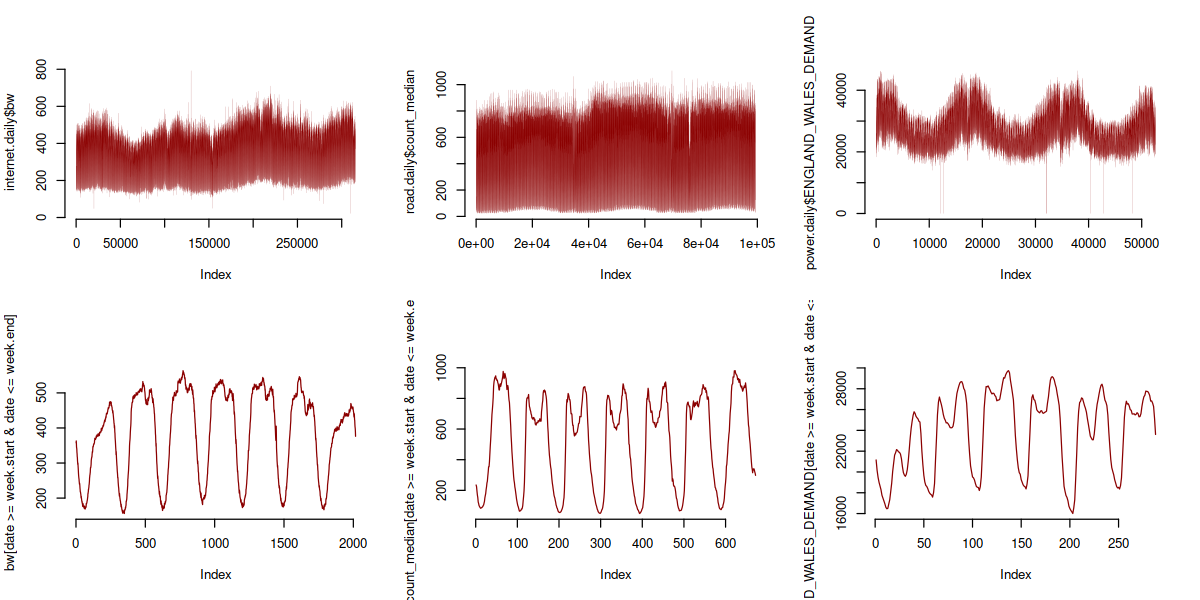

In [10]:
# for tech article (superfluouria)
week.start <- "2018-06-10"
week.end <- "2018-06-16"
options(repr.plot.width=10, repr.plot.height=5)
par(bty="n", mfrow=(c(2, 3)))
plot(internet.daily$bw, type="l", lwd=0.1, col=line.colour)
plot(road.daily$count_median, type="l", lwd=0.1, col=line.colour)
plot(power.daily$ENGLAND_WALES_DEMAND, type="l", lwd=0.1, col=line.colour)
with(internet.daily, plot(bw[date >= week.start & date <= week.end], type="l", col=line.colour))
with(road.daily, plot(count_median[date >= week.start & date <= week.end], type="l", col=line.colour))
with(power.daily, plot(ENGLAND_WALES_DEMAND[date >= week.start & date <= week.end], type="l", col=line.colour))

## qa model

have already constructed a model for each series using SSA. as an alternative, use the mean of the previous month of observations for a specific interval in the day as the expected value. for example, for 9am on a wednesday, it's expected value is the mean of the previous 4 wednesday 9am's. this should be done on the seasonally adjusted data `series - trend - monthly seasonality`. the expected value is then `trend + monthly seasonality + expected value`.

In [11]:
#internet.daily[nrow(internet.daily) - (1:4 * 7*24*60/5), ]
internet.daily$mean_model <- with(internet.daily, {
    #trend + winter_summer + wapply(bw - trend - winter_summer, 1:4 * 7*24*60/5, median)
    wapply(bw, 1:4 * 7*24*60/5, mean)
})

In [12]:
#road.daily[nrow(road.daily) - (1:4 * 7*24*60/15), ]
#tail(road.daily, 1)
road.daily$mean_model <- with(road.daily, wapply(count_median, 1:4 * 7*24*60/15, mean))

In [13]:
#power.daily[nrow(power.daily) - (1:4 * 7*24*60/30), ]
#tail(power.daily, 1)
power.daily$mean_model <- with(power.daily, wapply(ENGLAND_WALES_DEMAND, 1:4 * 7*24*60/30, mean))

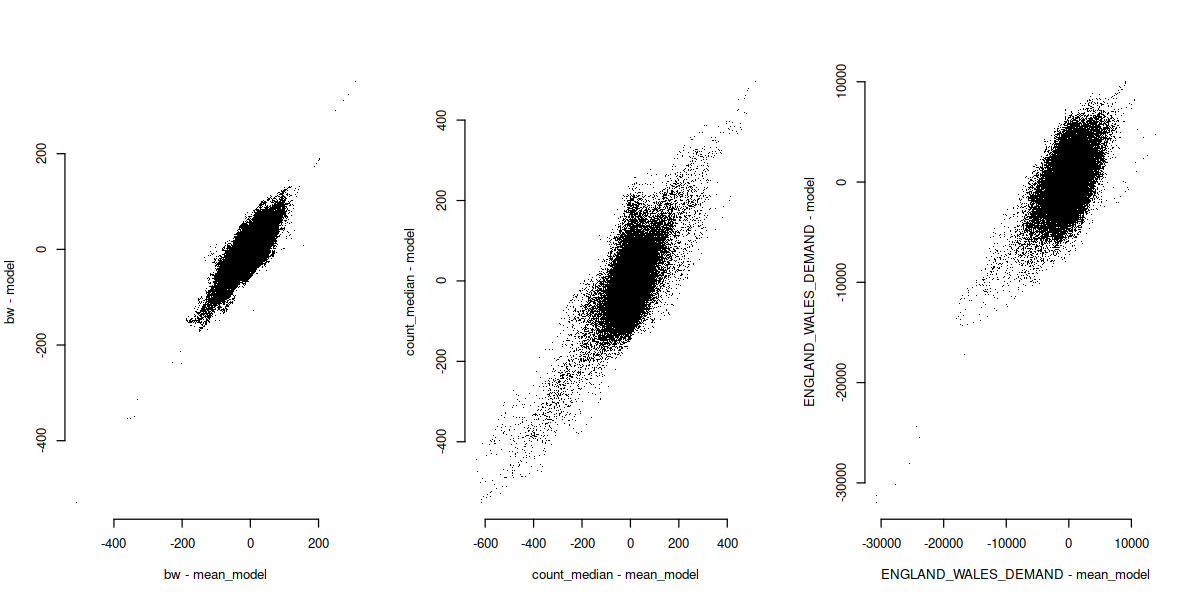

In [14]:
# check that ssa model residuals are similar to naive 4 week average window model
par(mfrow=c(1,3), bty="n")
with(internet.daily, plot(bw - mean_model, bw - model, pch="."))
with(road.daily, plot(count_median - mean_model, count_median - model, pch="."))
with(power.daily, plot(ENGLAND_WALES_DEMAND - mean_model, ENGLAND_WALES_DEMAND - model, pch="."))

In [15]:
# the top quantiles for ssa residuals (residuals not normally distributed, so not using 2*std for .95 bleh)
quants <- quantile(with(internet.daily, bw - model), probs=c(0.001, 0.01, 0.05, 0.95, 0.99, 0.999))
quants

0.1%         1%         5%        95%        99%      99.9% 
-130.58562  -74.72662  -39.38186   38.83356   60.58737   93.70729

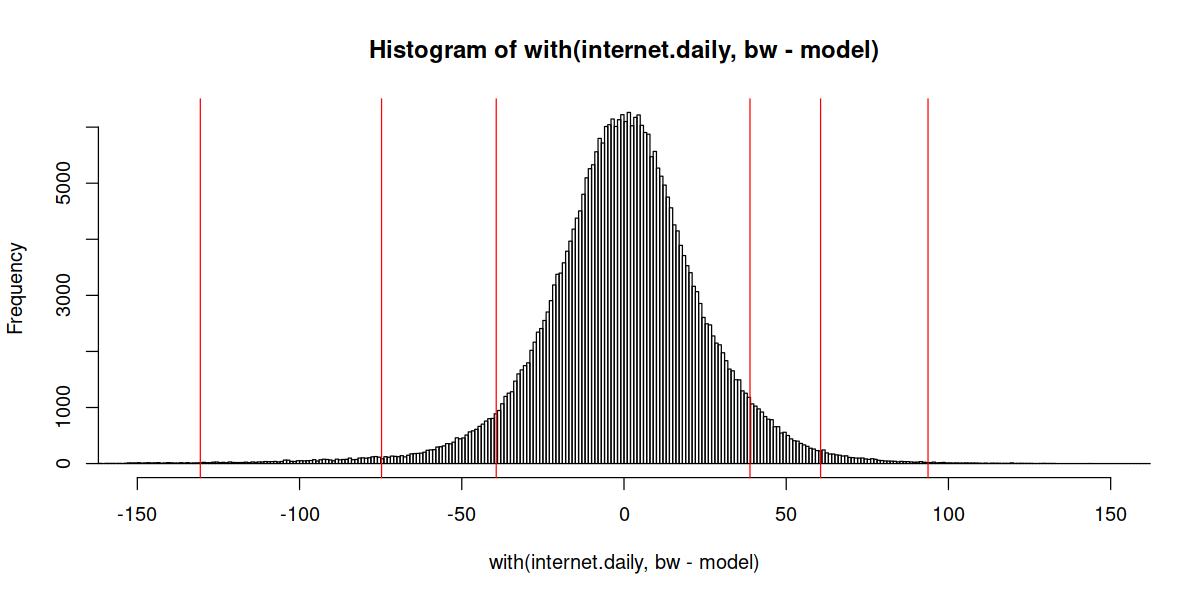

In [16]:
# seems legit
options(repr.plot.width=10, repr.plot.height=5)
hist(with(internet.daily, bw - model), breaks=1000, xlim=c(-150, 150))
abline(v=quants, col="red")

In [17]:
# ^-- above
with(internet.daily, shapiro.test(sample(bw - model, 5000)))


	Shapiro-Wilk normality test

data:  sample(bw - model, 5000)
W = 0.96449, p-value < 2.2e-16


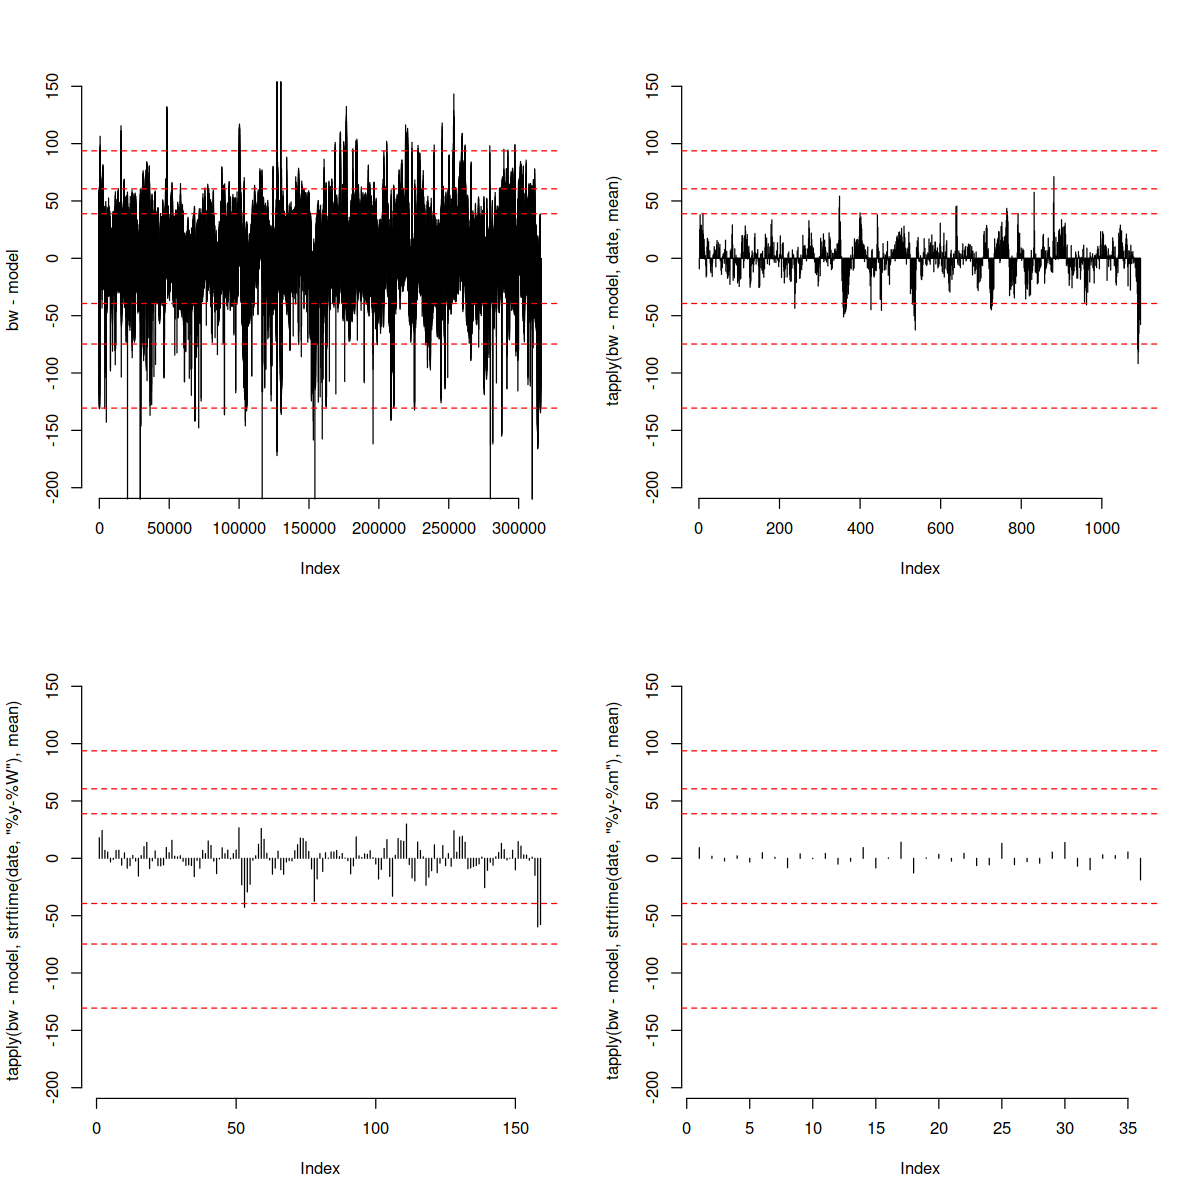

In [18]:
# see how percentiles look 5 minute, daily, weekly, monthly.
# daily should probably have its own level.
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow=c(2,2),bty="n")
with(internet.daily, {
    plot(bw - model, type="h", ylim=1.5*range(quants))
    abline(h=quants, col="red", lty=2)
    plot(tapply(bw - model, date, mean), type="h", ylim=1.5*range(quants))
    abline(h=quants, col="red", lty=2)
    plot(tapply(bw - model, strftime(date, "%y-%W"), mean), type="h", ylim=1.5*range(quants))
    abline(h=quants, col="red", lty=2)
    plot(tapply(bw - model, strftime(date, "%y-%m"), mean), type="h", ylim=1.5*range(quants))
    abline(h=quants, col="red", lty=2)
})

In [19]:
# idea: the significane of a residual is not it's percentile but instead it's persistence >= percentile level.
# - ignore 5 min spikes and look at residuals consitently +- .95, .99, .999 level.
# consistency = "drawdown" or "time under water" - the time the residual was above or below levels..
# apply this daily.

# todo: move this into daily feature generation.

L <- quants[1]
H <- quants[6]

daily_drawdown <- function(L=quants[1], H=quants[6]) {
    daily.drawdown <- as.vector(with(internet.daily, {
        tapply(bw - model, date, function(x) {
            max.H <- max(0, with(rle(x > H),lengths[values])) # max run length encoding = max continuous time > H.95
            max.L <- max(0, with(rle(x < L),lengths[values]))
            max(max.H, max.L) # max of both
        })
    }))
}
    
daily.drawdown.95  <- daily_drawdown(quants[3], quants[4])
daily.drawdown.99  <- daily_drawdown(quants[2], quants[5])
daily.drawdown.999 <- daily_drawdown(quants[1], quants[6])


m <- with(internet.daily, tapply(bw - model, date, mean))

drawdowns <- data.frame(date=internet.daily.features$X, d999=daily.drawdown.999, d99=daily.drawdown.99, d95=daily.drawdown.95,
                        mew=m)

#check (cols=percentiles, row 1=number >percentile, 2=max continuous drawdown)
matrix(c(
sum(daily.drawdown.95>0),
sum(daily.drawdown.99>0),
sum(daily.drawdown.999>0),
max(daily.drawdown.95),
max(daily.drawdown.99),
max(daily.drawdown.999)
),nrow=2)

length(m)

head(drawdowns)
nrow(drawdowns)


[,1] [,2] [,3]
[1,] 850   62  191 
[2,] 303  212   83

[1] 1096

date       d999 d99 d95 mew      
2016-01-01 2016-01-01 3    51  80  -9.097272
2016-01-02 2016-01-02 3    19  54  24.952439
2016-01-03 2016-01-03 2    34  65  37.809871
2016-01-04 2016-01-04 0     4  36  28.592625
2016-01-05 2016-01-05 0     2  45  22.214475
2016-01-06 2016-01-06 0     0  48  28.812514

[1] 1096

In [20]:
# 99.9%
dates <- internet.daily.features$X # from the daily features
#head(sort(daily.drawdown.999, decreasing = T), 10)
# order days where residual > 99.9% for longest period of time
head(dates[order(-daily.drawdown.999)], 20)

[1] "2018-12-24" "2018-05-30" "2018-12-25" "2018-12-26" "2017-09-05"
 [6] "2016-08-25" "2016-06-16" "2018-06-20" "2018-02-03" "2016-12-14"
[11] "2018-01-30" "2018-02-04" "2018-05-01" "2017-08-21" "2017-03-27"
[16] "2018-02-02" "2016-02-23" "2017-03-17" "2017-08-30" "2017-10-01"

note: https://en.wikipedia.org/wiki/Portal:Current_events handy.


* 2018-12-24 xmas eve (non bh)
* 2018-05-30 (wed) ? 2 days after 28 may bh
* 2018-12-25 xmas day
* 2018-12-26 boxing
* 2017-09-05 ????? Hurricane Irma becomes the most powerful hurricane ever recorded in the Atlantic Basin region with winds of 185mph (280km/h) ?????
* 2016-08-25 mon ? massive central italy earthquake.. 6.2. :(
* 2016-06-16 ? https://en.wikipedia.org/wiki/Portal:Current_events/June_2016 (Labour Party MP Jo Cox dies) (note: i'm just looking for news. this event might not be related - only thing i can find on the day)
* 2018-06-20 ? southgate tube explosion? https://www.theguardian.com/uk-news/2018/jun/20/man-arrested-over-southgate-tube-station-explosion-north-london
* 2018-02-03 ? shot down russian piot in syra? https://en.wikipedia.org/wiki/Portal:Current_events/February_2018
* 2016-12-14 ? Yahoo! announces that ID information about more than 1 billion accounts may have been hacked in August 2013. This is separate from the company's earlier disclosure of a data  + A U.S. airstrike in Al-Raqqah, Syria, kills four ISIL leaders, two of which were confirmed to have roles in the November 2015 Paris Attacks. (USA via MSN)
* 2018-01-30 ?
* 2018-02-04 ?
* 2018-05-01
* 2017-08-21
* 2017-03-27
* 2018-02-02
* 2016-02-23
* 2017-03-17
* 2017-08-30
* 2017-10-01

In [21]:
# 99%
dates <- internet.daily.features$X # from the daily features
# order days where residual > 99.9% for longest period of time
head(dates[order(-daily.drawdown.99)], 20)

[1] "2018-12-25" "2018-12-24" "2018-05-30" "2018-12-31" "2018-12-26"
 [6] "2017-12-24" "2018-03-02" "2017-06-17" "2017-06-19" "2017-12-28"
[11] "2018-12-27" "2017-03-02" "2016-12-29" "2018-05-29" "2016-12-24"
[16] "2016-12-27" "2017-12-26" "2017-06-20" "2018-08-19" "2018-01-01"

* 2018-12-25 xmas day
* 2018-12-24 xmas eve (non bh)
* 2018-05-30 ?
* 2018-12-31 new years eve (non bh)
* 2018-12-26 boxing day
* 2017-12-24 xmas eve
* 2018-03-02 ? A massive winter storm occurs in the East Coast of the United States, leaving millions without power and cancelling thousands of airplane flights. (CNN via MSN)
* 2017-06-17 ? 
* 2017-06-19 ? 2017 Finsbury Park attack - https://en.wikipedia.org/wiki/2017_Finsbury_Park_attack
* 2017-12-28 ? xmas period

* 2018-12-27 ? xmas period
* 2017-03-02
* 2016-12-29
* 2018-05-29
* 2016-12-24
* 2016-12-27
* 2017-12-26
* 2017-06-20
* 2018-08-19
* 2018-01-01

In [22]:
# 95%
dates <- internet.daily.features$X # from the daily features
head(sort(daily.drawdown.95, decreasing = T), 10)
# order days where residual > 99.9% for longest period of time
head(dates[order(-daily.drawdown.95)], 100)

[1] 212 206 196 195 194 192 191 188 172 170

[1] "2018-12-25" "2018-12-26" "2018-12-24" "2018-12-31" "2018-12-27"
  [6] "2016-12-24" "2018-12-28" "2017-06-20" "2016-12-30" "2017-06-18"
 [11] "2018-05-30" "2016-12-23" "2017-06-19" "2017-06-17" "2016-12-29"
 [16] "2017-12-28" "2017-10-01" "2017-03-28" "2017-03-02" "2018-03-02"
 [21] "2016-04-24" "2017-09-29" "2016-12-27" "2017-12-24" "2016-04-29"
 [26] "2018-04-11" "2017-01-02" "2018-08-27" "2017-12-26" "2016-12-28"
 [31] "2017-12-29" "2018-05-07" "2016-12-13" "2018-06-25" "2018-03-30"
 [36] "2017-12-25" "2017-06-15" "2018-01-01" "2018-12-23" "2017-09-30"
 [41] "2018-04-02" "2016-01-10" "2018-08-19" "2018-02-03" "2017-06-13"
 [46] "2017-03-18" "2017-12-22" "2016-04-13" "2018-02-01" "2018-10-31"
 [51] "2016-04-28" "2016-08-24" "2018-03-06" "2016-01-01" "2018-12-21"
 [56] "2018-05-29" "2016-08-25" "2017-09-14" "2018-06-22" "2018-03-03"
 [61] "2017-09-05" "2016-06-29" "2016-04-25" "2016-12-26" "2017-03-25"
 [66] "2017-12-23" "2018-02-04" "2018-03-21" "2018-11-14" "2016-12-31"
 [71] "2018-02-02" "2018-08-13" "2017-01-01" "2016-01-03" "2016-05-18"
 [76] "2016-08-26" "2016-12-14" "2017-02-03" "2018-11-30" "2016-06-13"
 [81] "2018-08-14" "2016-08-29" "2017-12-27" "2018-06-20" "2016-03-28"
 [86] "2017-02-05" "2018-03-04" "2017-02-02" "2017-04-17" "2018-02-15"
 [91] "2017-02-04" "2017-08-21" "2016-12-22" "2017-03-26" "2017-12-14"
 [96] "2017-12-31" "2018-01-20" "2018-01-21" "2018-06-12" "2016-01-02"

* 2018-12-25 xmas day
* 2018-12-26 boxing day
* 2018-12-24 xmas eve
* 2018-12-31 new years eve
* 2018-12-27 ?
* 2016-12-24 xmas eve
* 2018-12-28 ?
* 2017-06-20 brussels attack - https://en.wikipedia.org/wiki/June_2017_Brussels_attack
* 2016-12-30 ?xmas
* 2017-06-18 ?lots happening this day inc. https://en.wikipedia.org/wiki/June_2017_Bamako_attack

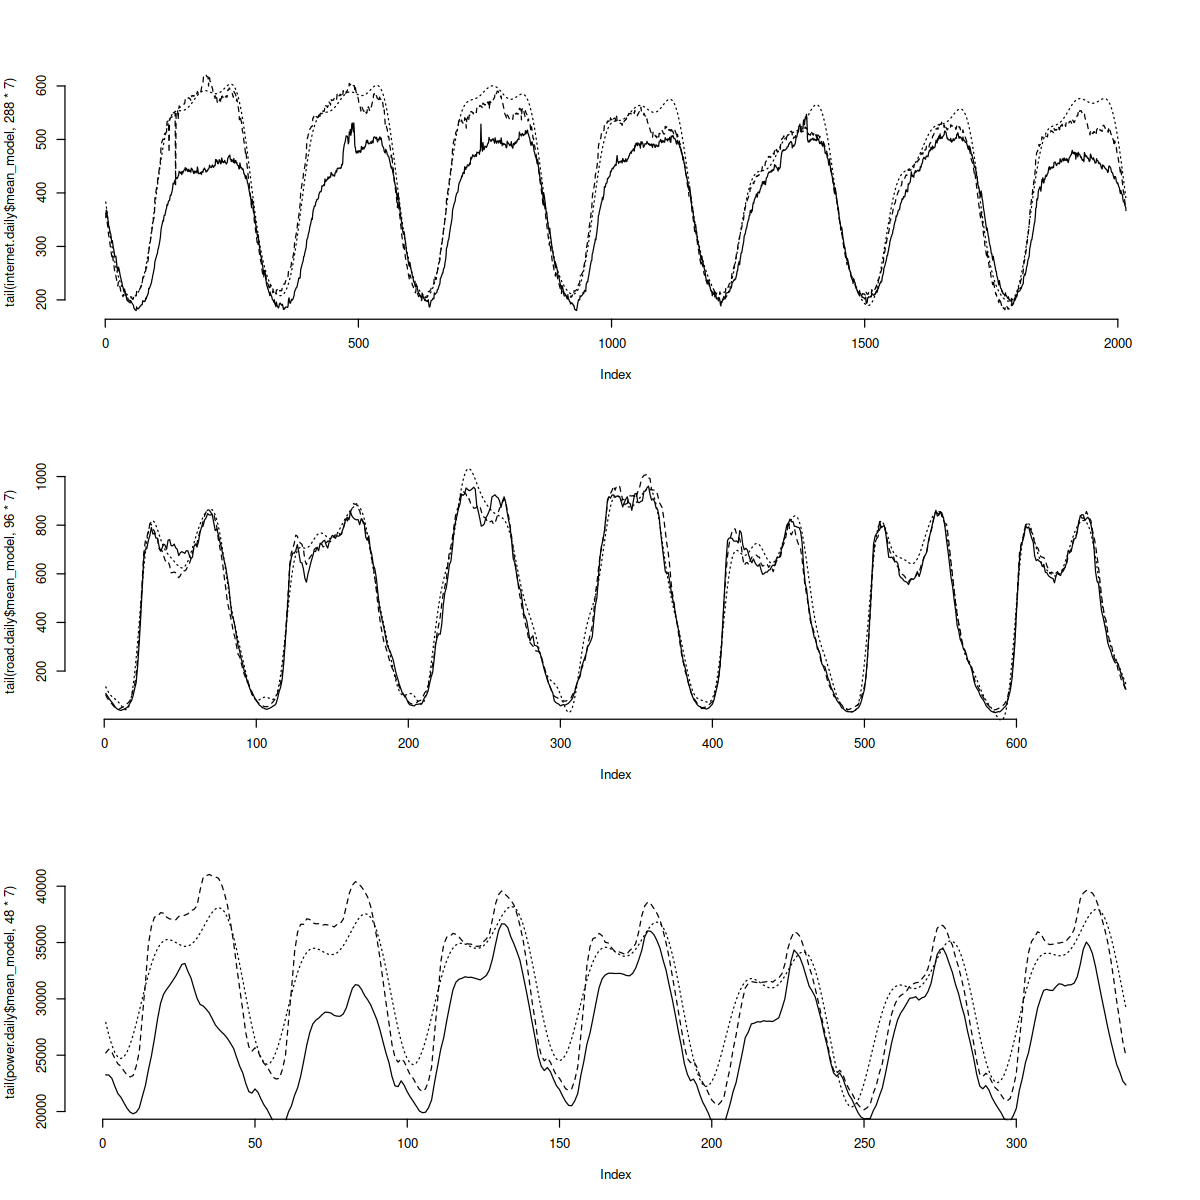

In [25]:
# quickly eyeball ssa vs naive 4 week model
# seems legit...
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow=c(3,1), bty="n")

plot(tail(internet.daily$mean_model, 288*7), lty=2, type="l")
lines(tail(internet.daily$bw, 288*7))
lines(tail(internet.daily$model, 288*7), lty=3)

plot(tail(road.daily$mean_model, 96*7), lty=2, type="l")
lines(tail(road.daily$count_median, 96*7))
lines(tail(road.daily$model, 96*7), lty=3)

plot(tail(power.daily$mean_model, 48*7), lty=2, type="l")
lines(tail(power.daily$ENGLAND_WALES_DEMAND, 48*7))
lines(tail(power.daily$model, 48*7), lty=3)

Some ideas for notable events

### 2016

* 7-8 February – Storm Imogen hits Britain, causing thousands of power outages and structural damage across the country, along with disruption for many commuters.
* 28 March – Storm Katie rips through parts of Britain through the Easter weekend and many parts of the country suffer damage. The storm causes disruption with many flights cancelled or diverted as a result
* 23 June: eu referendum
* 24 June: result
* 1st july  two-minute silence is observed at 7.28 a.m.
* Friday, 25 November - black friday


### 2017

* 9th jan: A strike by workers on London Underground causes travel chaos and crowding in London, with much of the Tube network shut down.
* 23rd feb: Britain is hit by winds of up to 94 mph from Storm Doris, causing travel disruption and a number of casualties.
* 22 March: london terror incident
* 12 May – Computers across the United Kingdom are hit by a large-scale ransomware cyber-attack, causing major disruption.
* 22 May: manchester terror incident
* 3 June: london terror incident
* 8 June: General snap election
* 19th june: london terror incident
* 21 June: heatwave
* 15 sept: london terror incident
* Friday, 24 November - black friday



### 2018
* 2–4 January – Storm Eleanor causes widespread disruption across the UK, with flooding and gusts of wind reaching 100 mph (161 km/h)
* 17 February: south wales earthquake?
* 24 feb: "Beast from the East" + storm emma snow.
* 27 February – 4 March – Heavy snow causes disruption across much of the UK
* 17/18 mar: "mini beast from east" (weekend snow)
* 3rd may: local elections
* 19th may: royal wedding (eyeroll)
* 20th may: "New train timetables cause severe disruption across the network affecting thousands of passengers."
* 22 May 1 minute silence 14:30 BST
* 24 june: eng vs panama
* 3 July – England's World Cup penalty shootout win over Colombia is watched by 23.6 million viewers, the highest peak audience for live sport since England played Portugal in the 2004 European Championships.
* 7 July – In the World Cup Quarter-finals, England win 2–0 against Sweden, taking them through to the Semi-finals on 11 July. It is the first time they have reached this stage since 1990. The match is live-streamed online by 3.8 million people, making it the BBC's highest online-viewed live programme ever.
* 11 July – England are defeated by Croatia in the World Cup Semi Final, losing 2–1.
* 26th july: The ongoing heatwave reaches its peak; temperatures at Faversham reach 35.3 °C (95.5 °F)—the hottest day of the year
* Friday, 23 November - black friday
* 6th december: O2 mobile network disruption

### 2018 residuals

#### all points

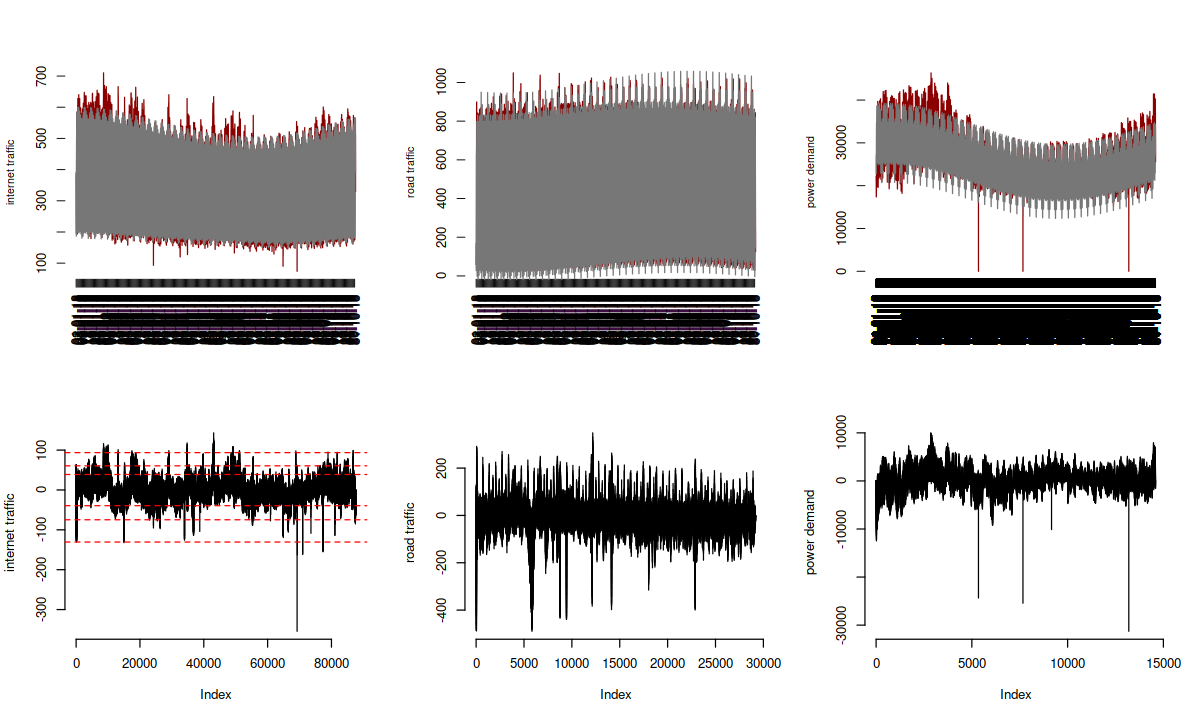

In [27]:
# just vis it looks ok,
plot_event_closeup(as.Date("2018-01-01"), as.Date("2018-10-31"))

##### mean day

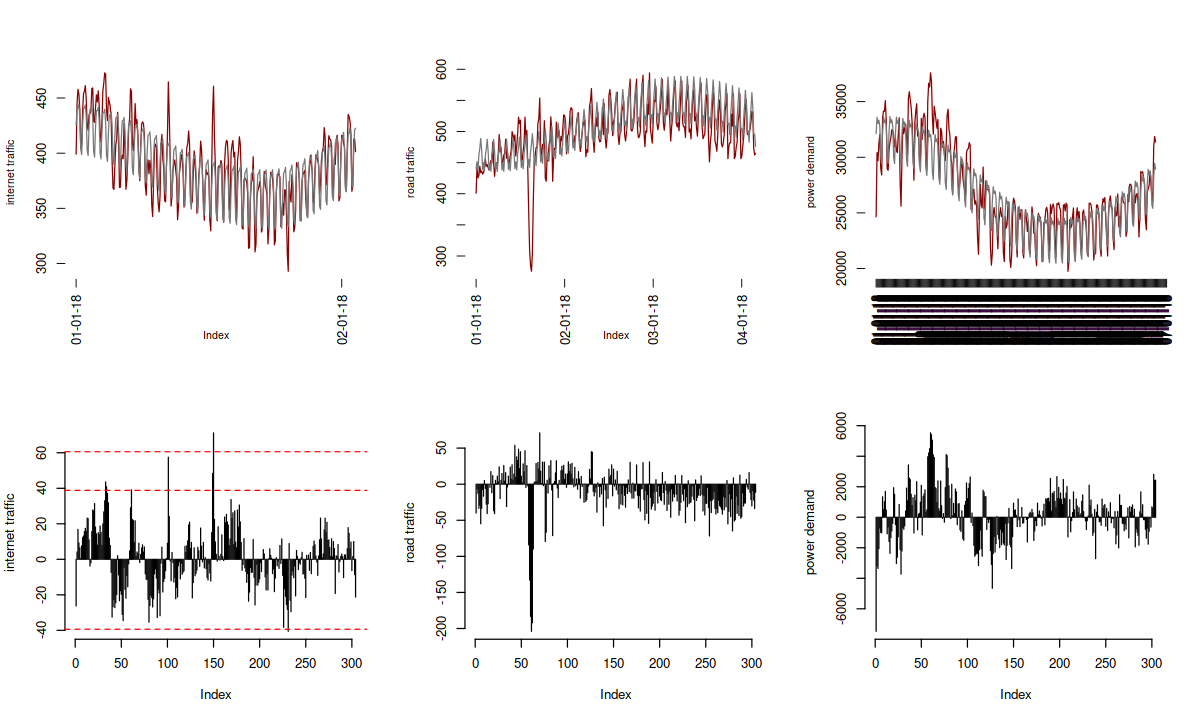

In [28]:
# ^-same
plot_event_closeup(as.Date("2018-01-01"), as.Date("2018-10-31"), daily=T)

### adverse weather conditions


#### Storm Imogen
On 6 February Met Éireann issued an amber warning for strong winds and named Storm Imogen. At this stage the Met Office had issued a yellow warning for strong winds in south-west England and South Wales. On 7 February, the Met Office yellow warning area was enlarged and an amber warning added for winds across south-western England of 60-70 mph and locally 80 mph on 8 February. They warned of the risk to trees, structures, interruption of power supplies and transport, especially the M4 and M5 motorways. On 8 February Storm Imogen brought trees down, produced large coastal waves, caused power cuts and toppled high-sided vehicles across southern England and Wales.

##### effects

nothing noteworthy.

* internet: none. except some temporary drop-outs. likely not related.
* road: higher in morning, lower rest of day. - average risidual seems to revert to 0 over next 2 days.
* power: higher for most of day.

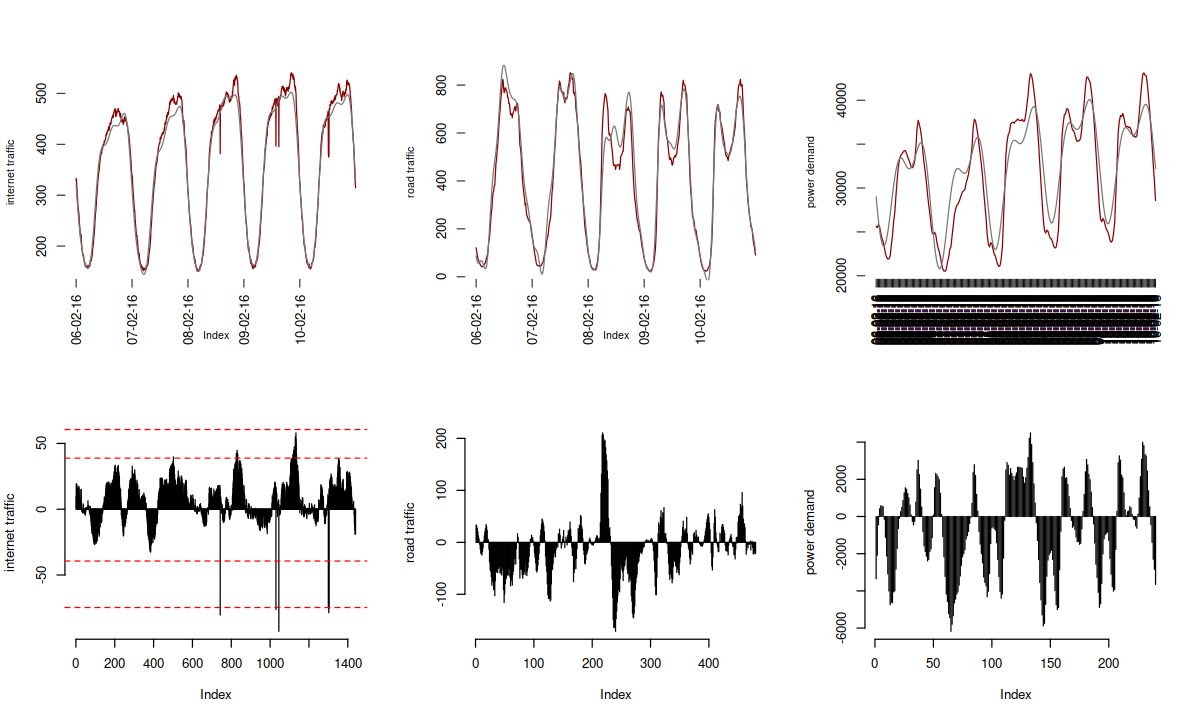

In [29]:
plot_event_closeup(as.Date("2016-02-08") - 2, as.Date("2016-02-08") + 2)

#### Storm Katie

Katie, the eleventh storm of the season, was named by the Met Office on Good Friday, 25 March. During the first half of Easter Monday, 28 March strong winds were experienced widely across southern England with coastal gusts of 70-80 mph and inland gusts of 50-70 mph in many places. The peak gust of 106 mph was recorded at the exposed site of The Needles Old Battery. Impacts were widespread across southern England including trees felled, wall, fence and roof damage, scaffolding collapses, bridge closures, flights, ferries and train cancellations and power outages.

##### effects

* **was easter monday on 28th, so diff likely due to that.**

* internet: slight overall reduction in traffic 
* road: significant morning drop
* power: drop on the day and day before

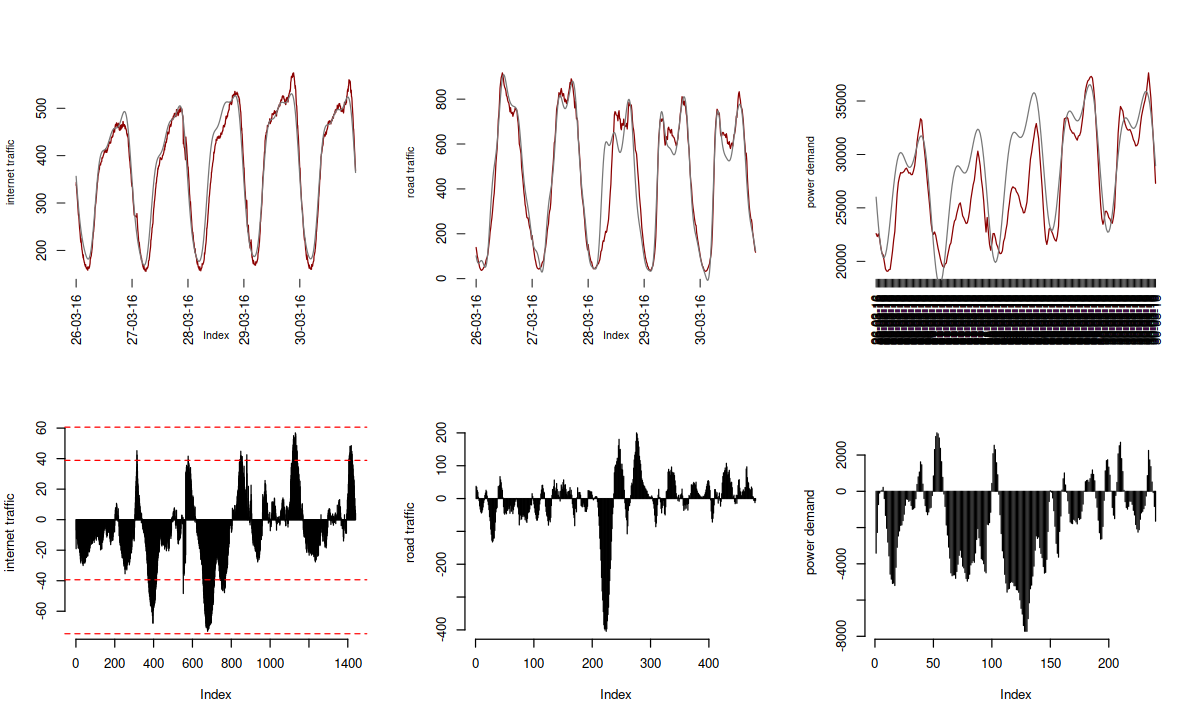

In [30]:
plot_event_closeup(as.Date("2016-03-28") - 2, as.Date("2016-03-28") + 2)

#### Storm Doris

Storm Doris was named on 21 February and impacted Ireland, the UK and the Netherlands on 23 February 2017.[27][28][29] A gust of 94 mph was recorded at Capel Curig, Wales.[30] On its approach the storm strengthened considerably going through a process called bombogenesis,[31] wherein the central pressure of the system fell at a very fast pace; 24 hPa of pressure in 24 hours to 974 millibars.

There was also snow and rain. Road, rail and air travel was disrupted and there were failures in power supply. The storm was described as a weather bomb.

##### effects

* lower road traffic.

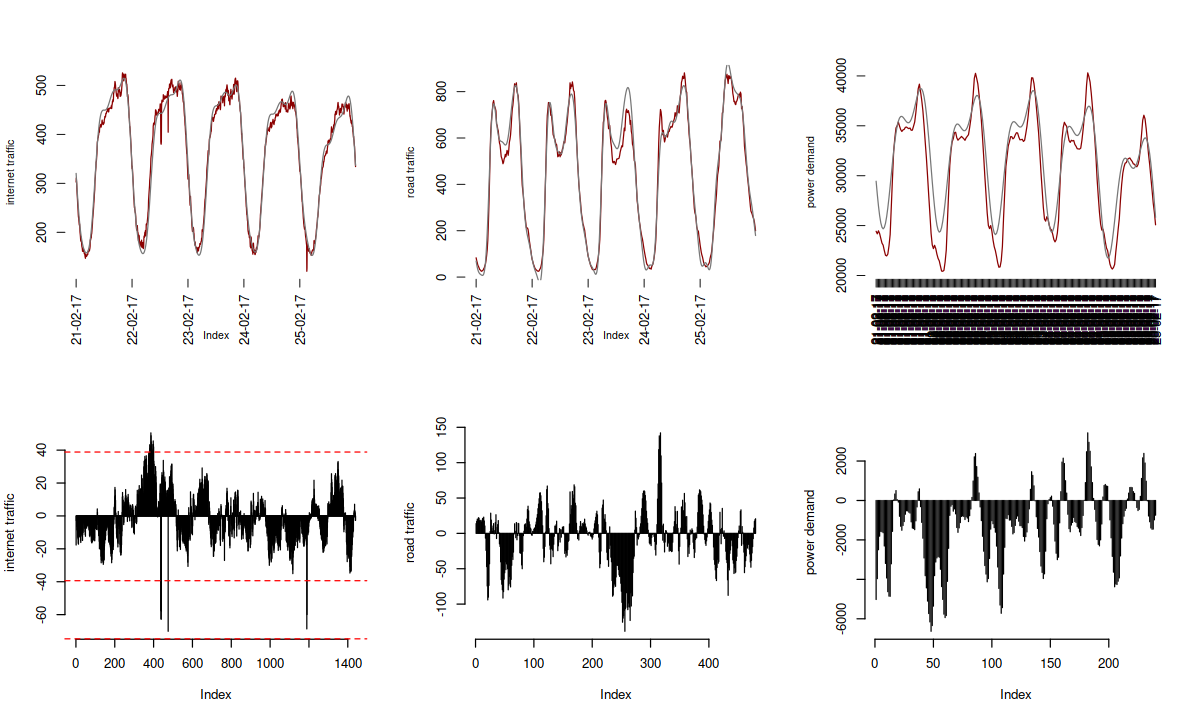

In [31]:
plot_event_closeup(as.Date("2017-02-23") - 2, as.Date("2017-02-23") + 2)

#### Storm Eleanor/Cyclone Burglind

Named by Met Éireann on 1 January with Amber Wind Warning in force for 2 January. Forecast to bring gusts of 110–130 km/h into the evening. The Met Office also issued a Yellow Wind Warning for 2–3 January, only to upgrade it to an amber warning across Northern England and Southern Scotland 3 hours prior making landfall in the UK.

##### effects

none -- too close to new year public holiday

#### Storm Emma & beast-from-the-east

# OBSERVABLE EFFECT

On 1 March 2018, UK authorities issued a red warning in Wales and south-west England as citizens in Scotland spent up to 20 hours in their cars stuck in traffic in frigid weather and a 46-year-old Southampton man died in a motor vehicle accident on the A34. Schools across the UK were closed in the face of oncoming blizzards, strong winds, and heavy snowfall. Traffic was significantly hindered by the Beast from the East.[105] In Lincolnshire commuters near Boston were stranded by snow and had to freed by farmers with tractors, a minimum of 20 cars and HGVs were snowed in on the A46 close to Faldingworth. The Royal Air Force deployed 4x4 vehicles to transport health and emergency workers.[106] Trains were cancelled across the UK, with over 20 rail operators running at reduced capacity; London's Paddington Station closed for about three hours and 50 stations in Kent closed because of inclement weather. Air travel has been similarly curtailed, as terminals all over the country cancel flights.

##### effects

* internet notable rise on 1st, 2nd march: heavy snowfall on those days.
* road: consistently lower. (lowest on snowfall days)
* power: consistently higher demand.

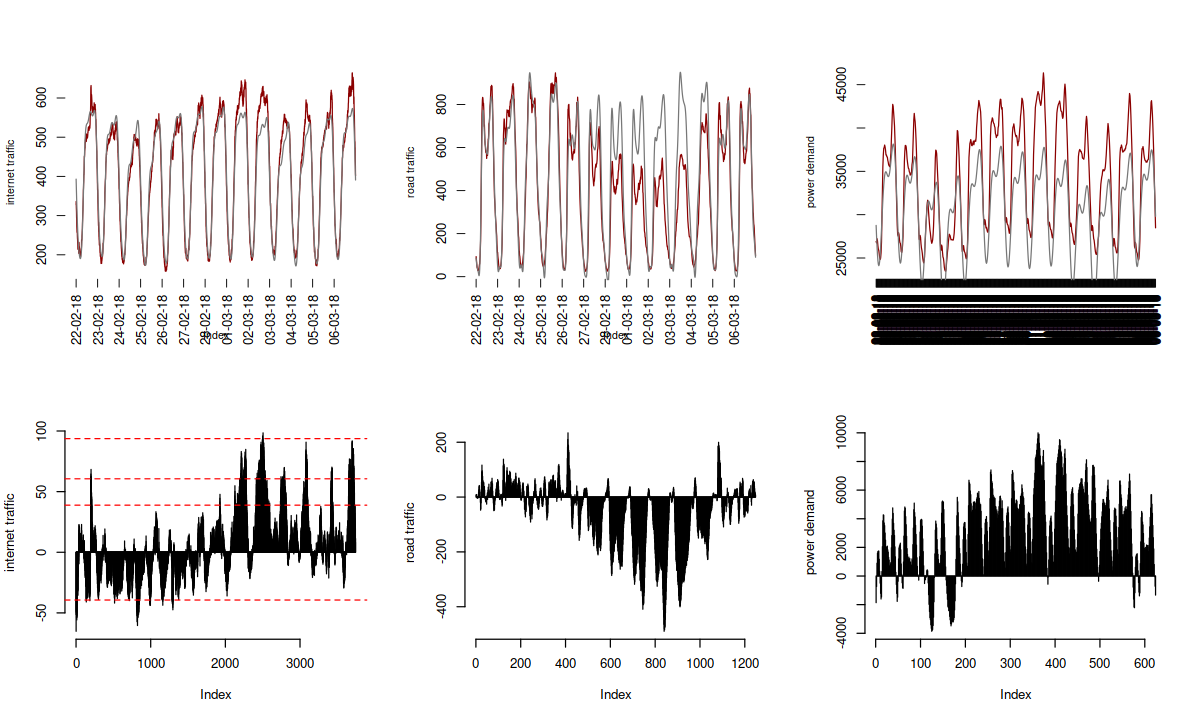

In [32]:
plot_event_closeup(as.Date("2018-02-24") - 2, as.Date("2018-03-04") + 2)

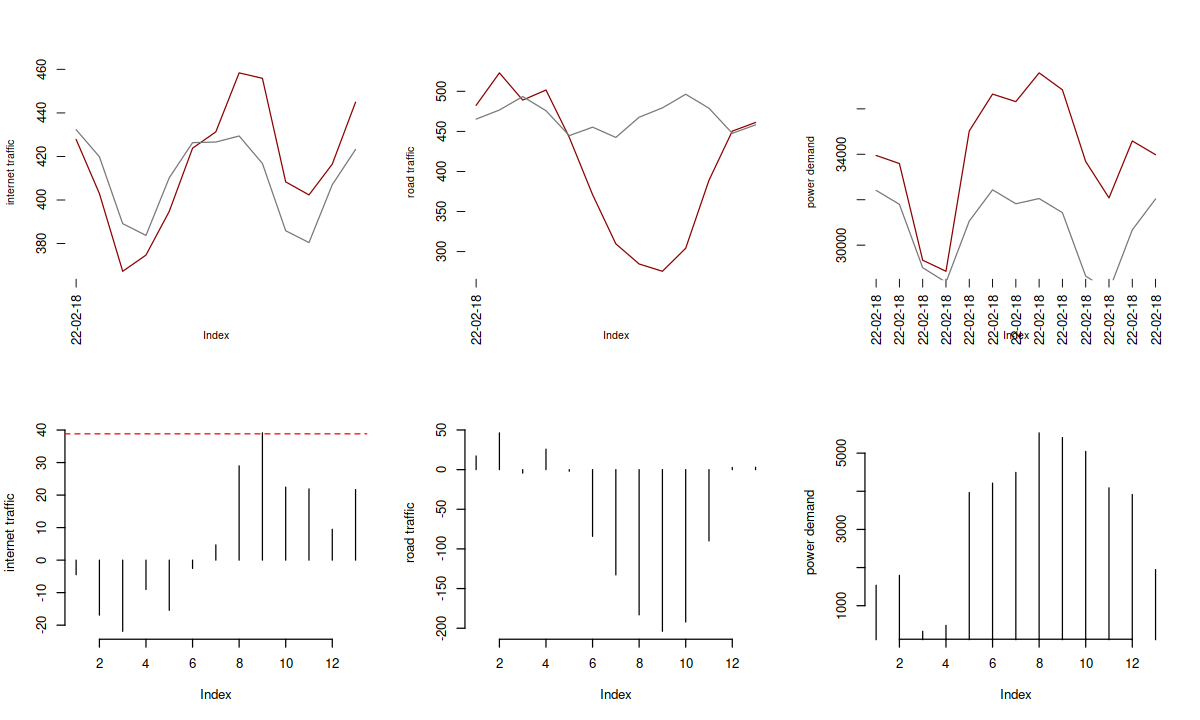

In [33]:
plot_event_closeup(as.Date("2018-02-24") - 2, as.Date("2018-03-04") + 2, daily=T)

### black-friday & cyber-monday (week)

#### 2016

##### effects
* internet: no noticable. - slight increase sunday before
* road: morning traffic peak on back friday
* power: consistently higher through cyber week

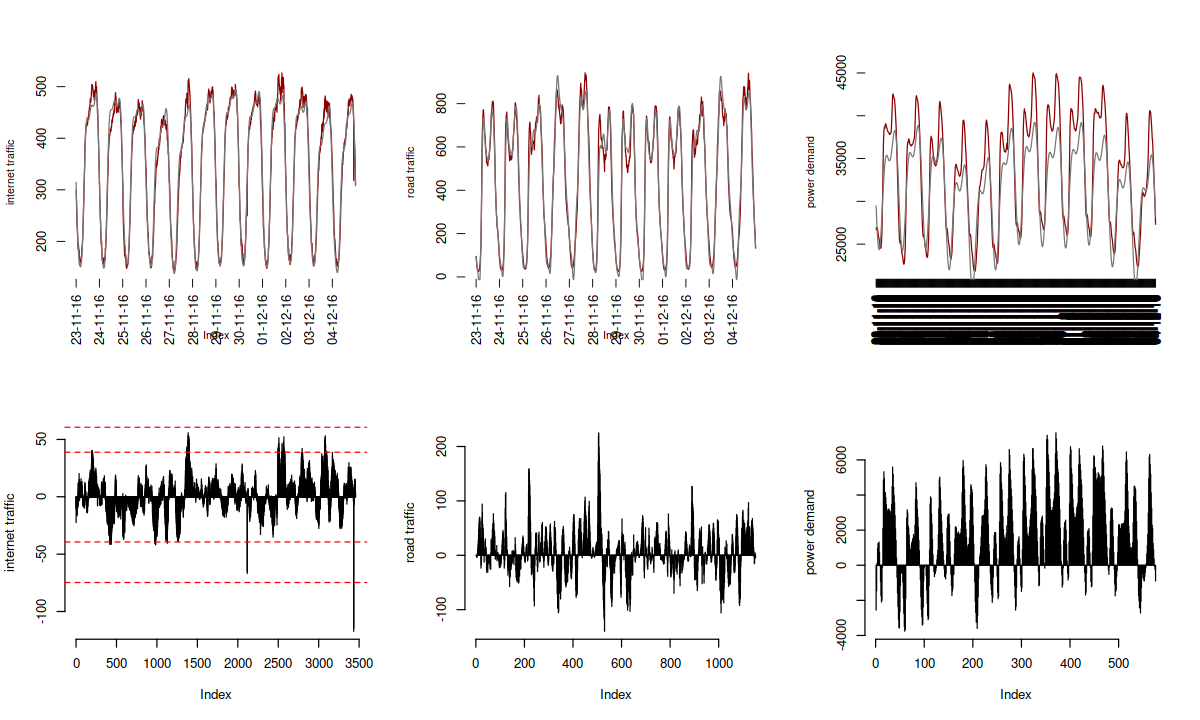

In [34]:
plot_event_closeup(as.Date("2016-11-25") - 2, as.Date("2016-12-02") + 2)

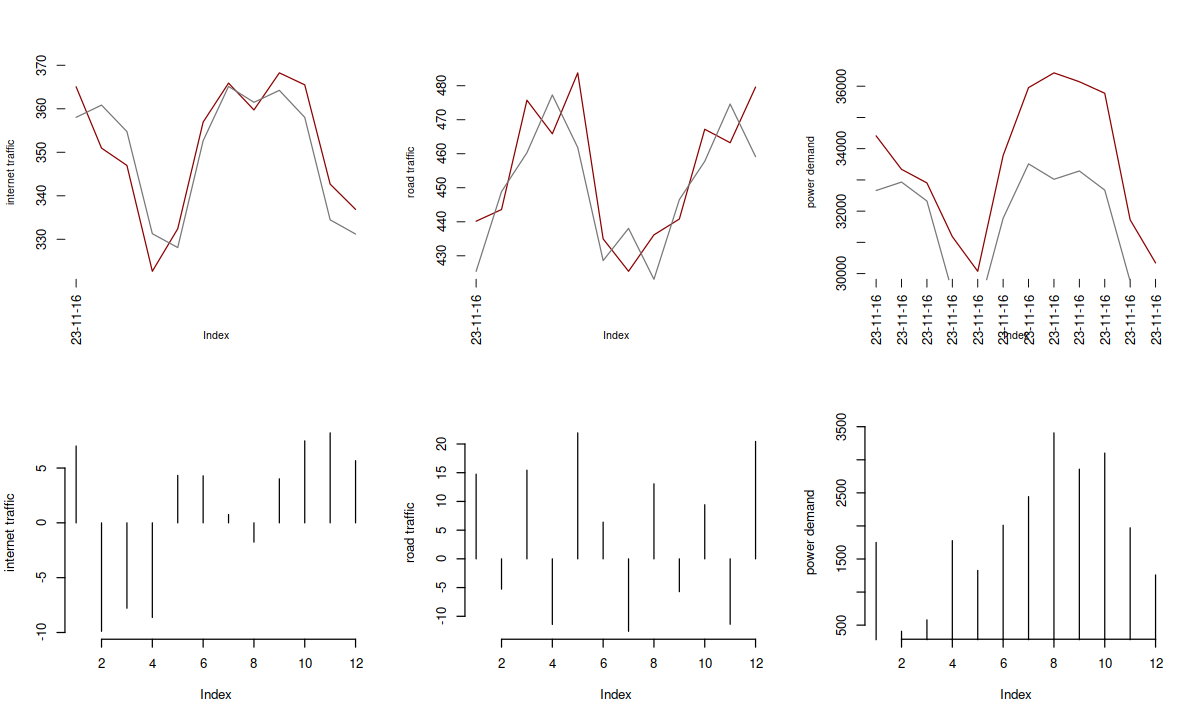

In [35]:
plot_event_closeup(as.Date("2016-11-25") - 2, as.Date("2016-12-02") + 2, daily=T)

##### 2017

##### effects

* internet: increase weekend before
* road: none
* power: increased demand through week. although this might be due to bad model.

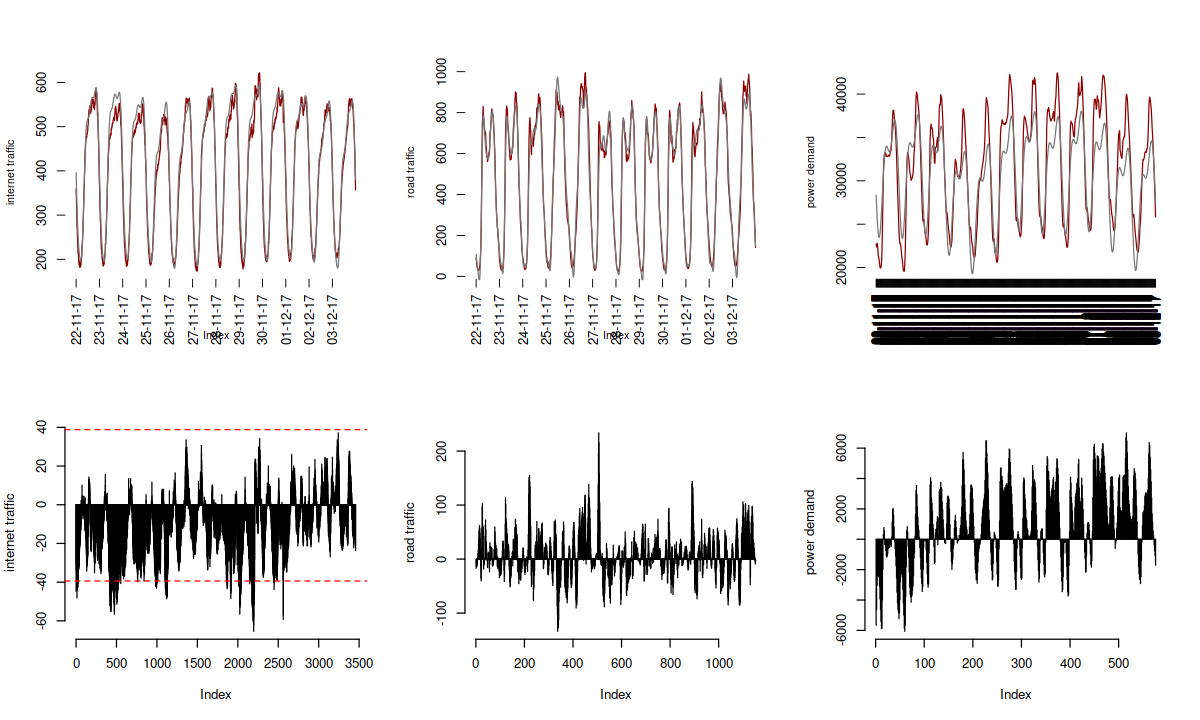

In [36]:
plot_event_closeup(as.Date("2017-11-24") - 2, as.Date("2017-12-01") + 2)

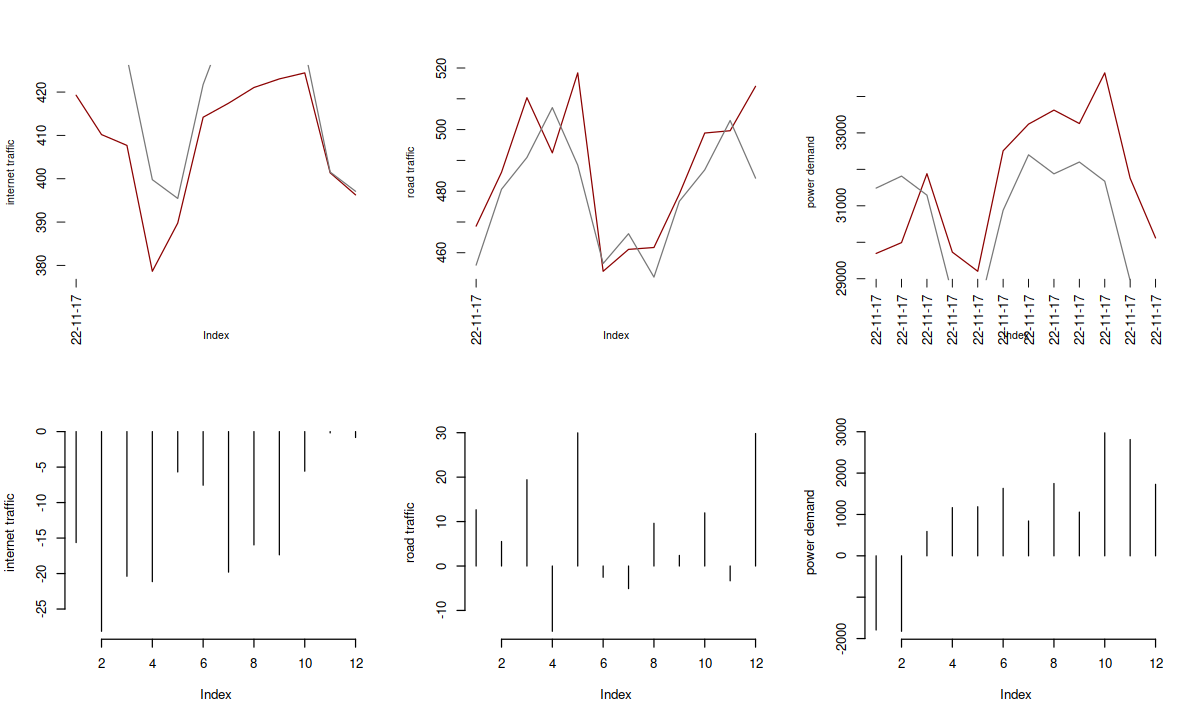

In [37]:
plot_event_closeup(as.Date("2017-11-24") - 2, as.Date("2017-12-01") + 2, daily=T)

##### 2018

##### effects

given past 2 years, this no longer seems so exciting. expected to see in previous years too.

* internet def higher on monday, continues through week.
* road: missing
* power: above. probably bad model.

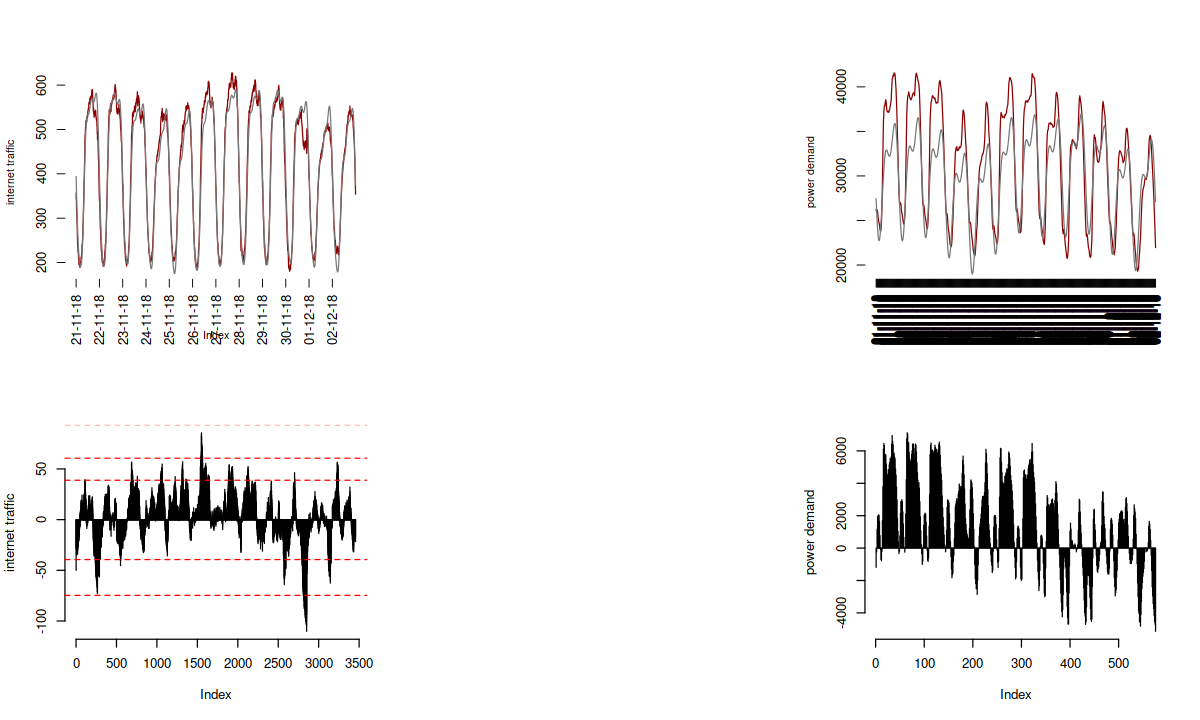

In [38]:
plot_event_closeup(as.Date("2018-11-23") - 2, as.Date("2018-11-30") + 2)

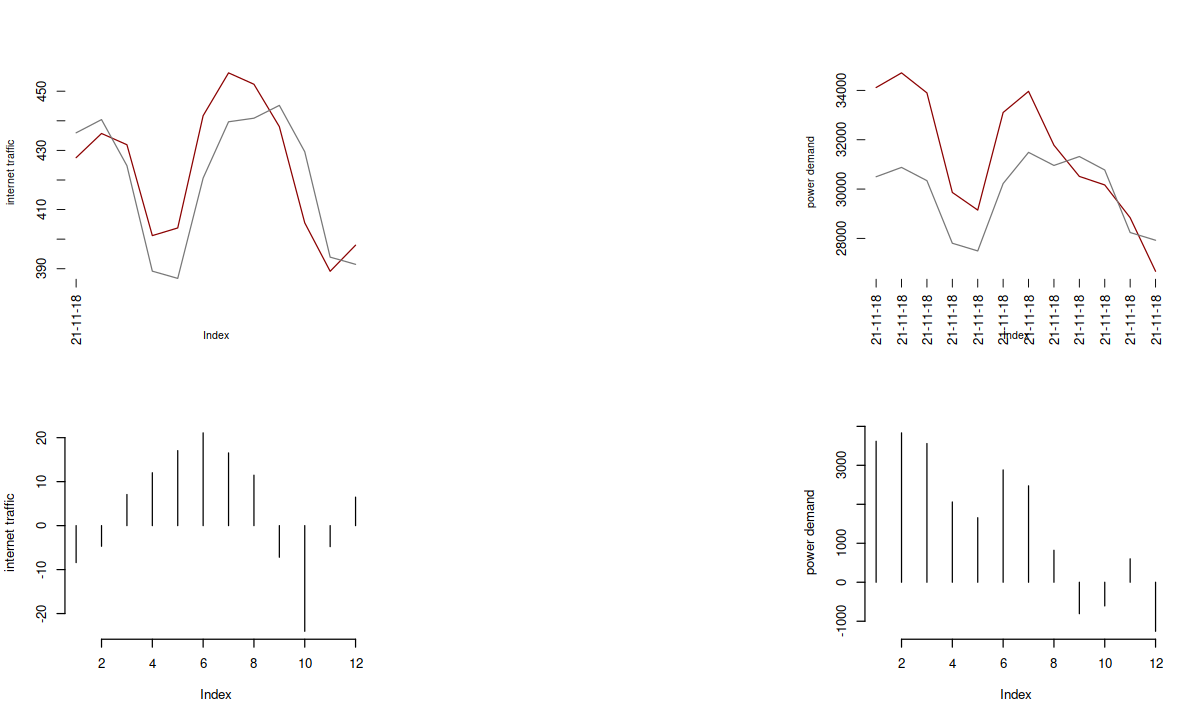

In [39]:
plot_event_closeup(as.Date("2018-11-23") - 2, as.Date("2018-11-30") + 2, daily=T)

#### comparison with monthly internet retail sales form same period (non food stores)

In [40]:
retail <- read.csv("../../data/econ/ISCPSA_internet_sales_value_of_internet_sales_at_current_prices_sa_2016-2018.csv", header=F)
colnames(retail) <- "x"
retail$month <- rep(1:12, 3)
retail$year <- rep(2016:2018, each=12)
retail

x     month year
1   91.1  1    2016
2   93.0  2    2016
3   91.1  3    2016
4   96.9  4    2016
5   96.3  5    2016
6   99.9  6    2016
7  100.1  7    2016
8  102.6  8    2016
9  103.1  9    2016
10 107.2 10    2016
11 109.6 11    2016
12 108.5 12    2016
13 107.9  1    2017
14 110.5  2    2017
15 110.1  3    2017
16 111.3  4    2017
17 109.4  5    2017
18 113.7  6    2017
19 119.1  7    2017
20 119.9  8    2017
21 118.7  9    2017
22 118.5 10    2017
23 123.8 11    2017
24 125.6 12    2017
25 127.1  1    2018
26 128.4  2    2018
27 133.1  3    2018
28 132.4  4    2018
29 137.2  5    2018
30 137.9  6    2018
31 139.8  7    2018
32 139.9  8    2018
33 140.1  9    2018
34 140.8 10    2018
35 142.2 11    2018
36 139.5 12    2018

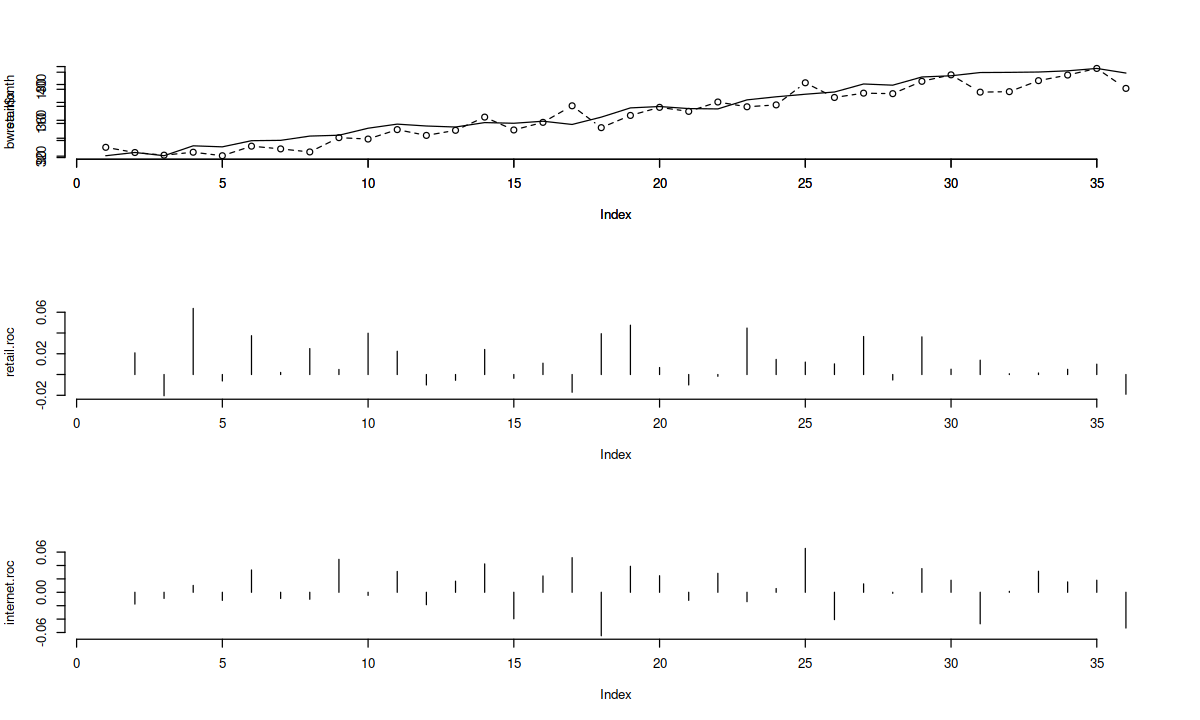

In [41]:
bw.sa <- internet.daily$bw - internet.daily$winter_summer
bw.sa <- data.frame(date=internet.daily$date, bw=bw.sa)
bw.sa$month <- strftime(as.Date(bw.sa$date), "%y_%m")
bw.sa.month <- as.vector(tapply(bw.sa$bw, bw.sa$month, mean))


par(mfrow=c(3,1), bty="n")
plot(retail$x, type="l")
par(new=T)
plot(bw.sa.month, type="b", lty=2)
retail.roc <- c(NA, diff(retail$x) / head(retail$x, -1))
internet.roc <- c(NA, diff(bw.sa.month) / head(bw.sa.month, -1))
plot(retail.roc, type="h")
plot(internet.roc, type="h")

In [42]:
cor.test(diff(bw.sa.month), diff(retail$x))
#cor.test(sign(internet.roc), sign(retail.roc))


	Pearson's product-moment correlation

data:  diff(bw.sa.month) and diff(retail$x)
t = 0.70479, df = 33, p-value = 0.4859
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2204165  0.4372762
sample estimates:
      cor 
0.1217748 


In [43]:
retail.roc[c(11, 23, 35)] # <- compared with october
diff(retail[c(11, 23, 35), ]$x) / retail[c(11, 23), ]$x # <- compared with november last year

[1] 0.022388060 0.044725738 0.009943182

[1] 0.1295620 0.1486268

In [44]:
#colnames(internet.daily.features)
#with(internet.daily.features[internet.daily.features$X %in% c("2016-11-28", "2017-11-27", "2018-11-26"), ], {
#    res.Mean /
#})

[1] 0.009706443

[1] -0.01709595

[1] 0.04774409

[1] 0.00137041

[1] -0.008860278

[1] 0.06191625

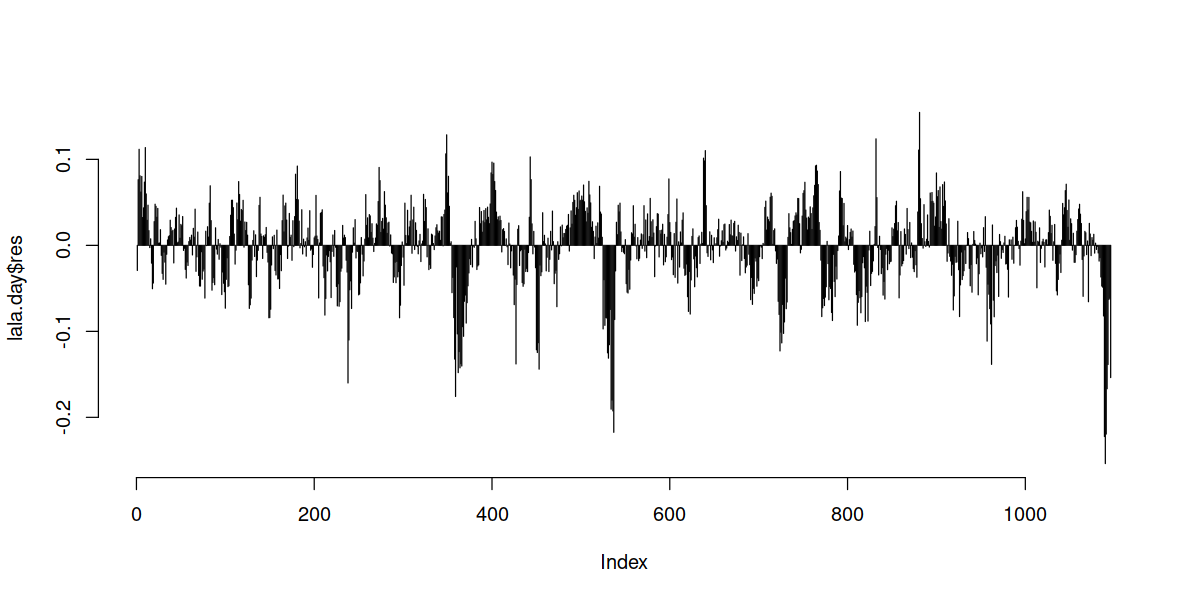

In [45]:
# *** something wrong with Mean in internet.daily.features. has not been calculated correctly. ***
# internet mean residual
res.2016 <- mean(with(internet.daily[internet.daily$date == "2016-11-28", ], bw - model)) / mean(with(internet.daily[internet.daily$date == "2018-11-26", ], bw))
res.2017 <- mean(with(internet.daily[internet.daily$date == "2017-11-27", ], bw - model)) / mean(with(internet.daily[internet.daily$date == "2018-11-26", ], bw))
res.2018 <- mean(with(internet.daily[internet.daily$date == "2018-11-26", ], bw - model)) / mean(with(internet.daily[internet.daily$date == "2018-11-26", ], bw))

res.2016
res.2017
res.2018

mew.bw <- tapply(internet.daily$bw, internet.daily$date, mean)
mew.model <- tapply(internet.daily$model, internet.daily$date, mean)
mew.res <- (mew.bw - mew.model) / mew.bw

mew.model.2 <- tapply(internet.daily$mean_model, internet.daily$date, mean)
mew.res.2 <- (mew.bw - mew.model.2) / mew.bw

res.2.2016 <- mean(with(internet.daily[internet.daily$date == "2016-11-28", ], bw - mean_model)) / mean(with(internet.daily[internet.daily$date == "2018-11-26", ], bw))
res.2.2017 <- mean(with(internet.daily[internet.daily$date == "2017-11-27", ], bw - mean_model)) / mean(with(internet.daily[internet.daily$date == "2018-11-26", ], bw))
res.2.2018 <- mean(with(internet.daily[internet.daily$date == "2018-11-26", ], bw - mean_model)) / mean(with(internet.daily[internet.daily$date == "2018-11-26", ], bw))

res.2.2016 
res.2.2017
res.2.2018

lala.day <- data.frame(date=as.Date(rownames(mew.res), tz="UTC"), res=mew.res)
lala.day.2 <- data.frame(date=as.Date(rownames(mew.res.2), tz="UTC"), res=mew.res.2)
options(repr.plot.width=10, repr.plot.height=5)
plot(lala.day$res, type="h", bty="n")

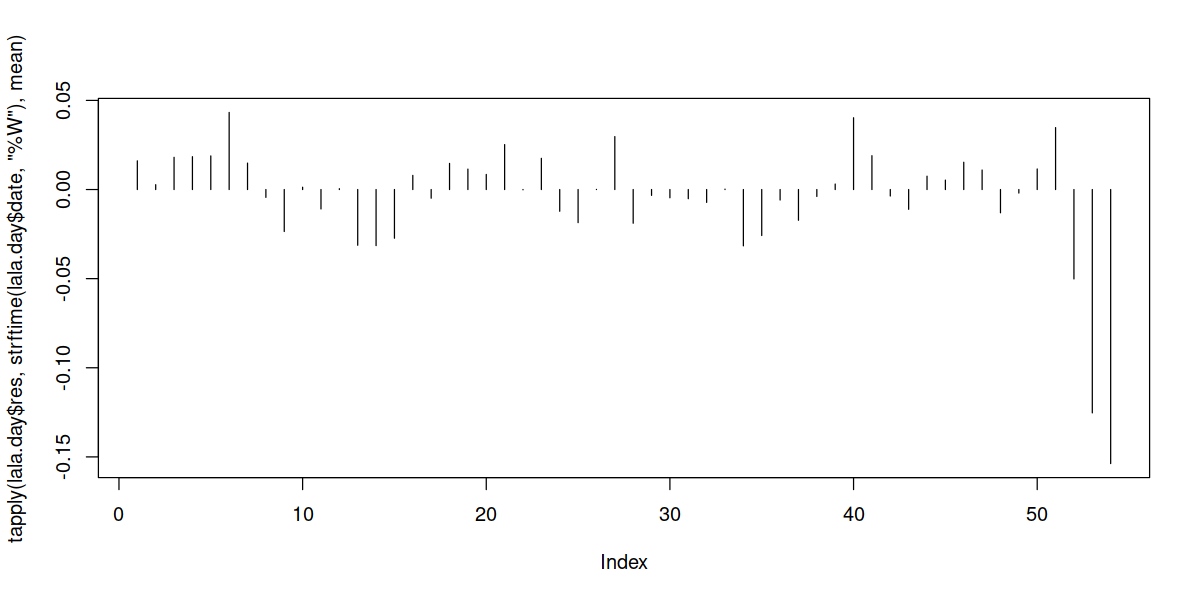

In [46]:
plot(tapply(lala.day$res, strftime(lala.day$date, "%W"), mean), type="h")

In [47]:
res.week.2016 <- with(lala.day, mean(res[date >= "2016-11-28" & date <= "2016-12-02"]))
res.week.2017 <- with(lala.day, mean(res[date >= "2017-11-27" & date <= "2017-12-01"]))
res.week.2018 <- with(lala.day, mean(res[date >= "2018-11-26" & date <= "2018-11-30"]))

res.week.2016.2 <- with(lala.day.2, mean(res[date >= "2016-11-28" & date <= "2016-12-02"]))
res.week.2017.2 <- with(lala.day.2, mean(res[date >= "2017-11-27" & date <= "2017-12-01"]))
res.week.2018.2 <- with(lala.day.2, mean(res[date >= "2018-11-26" & date <= "2018-11-30"]))

res.week.2016
res.week.2017
res.week.2018

res.week.2016.2
res.week.2017.2
res.week.2018.2

[1] 0.008118169

[1] -0.03154775

[1] 0.006734092

[1] 0.01793758

[1] -0.007694452

[1] 0.02759524

In [48]:
# retail compared with "expected" november: interpolated point between oct and dec.
retail.exp.2016 <- with(retail[retail$year == 2016, ], x[month == 11] - ((x[month == 10] + x[month == 12]) / 2))
retail.exp.2017 <- with(retail[retail$year == 2017, ], x[month == 11] - ((x[month == 10] + x[month == 12]) / 2))
retail.exp.2018 <- with(retail[retail$year == 2018, ], x[month == 11] - ((x[month == 10] + x[month == 12]) / 2))

retail.exp.2016
retail.exp.2017
retail.exp.2018

[1] 1.75

[1] 1.75

[1] 2.05

In [49]:
# retail compared with december
retail.exp.dec.2016 <- with(retail[retail$year == 2016, ], x[month == 11] - x[month == 12])
retail.exp.dec.2017 <- with(retail[retail$year == 2017, ], x[month == 11] - x[month == 12])
retail.exp.dec.2018 <- with(retail[retail$year == 2018, ], x[month == 11] - x[month == 12])

retail.exp.dec.2016 
retail.exp.dec.2017
retail.exp.dec.2018

[1] 1.1

[1] -1.8

[1] 2.7

In [50]:
cyber.monday.combo <- data.frame(year=2016:2018, internet.mon.res=c(res.2016, res.2017, res.2018), internet.mon.res2=c(res.2.2016, res.2.2017, res.2.2018), internet.week=c(res.week.2016, res.week.2017, res.week.2018), internet.week.2=c(res.week.2016.2, res.week.2017.2, res.week.2018.2), exp=c(retail.exp.2016, retail.exp.2017, retail.exp.2018), vs.dec=c(retail.exp.dec.2016, retail.exp.dec.2017, retail.exp.dec.2018), val=c(109.6, 123.8, 142.2))
cyber.monday.combo

year internet.mon.res internet.mon.res2 internet.week internet.week.2 exp 
1 2016  0.009706443      0.001370410       0.008118169   0.017937579    1.75
2 2017 -0.017095948     -0.008860278      -0.031547750  -0.007694452    1.75
3 2018  0.047744093      0.061916249       0.006734092   0.027595240    2.05
  vs.dec val  
1  1.1   109.6
2 -1.8   123.8
3  2.7   142.2

### public holidays

#### xmas 2017 +- 10 days

* continuous drawdown over xmas period.
* internet + power very similar

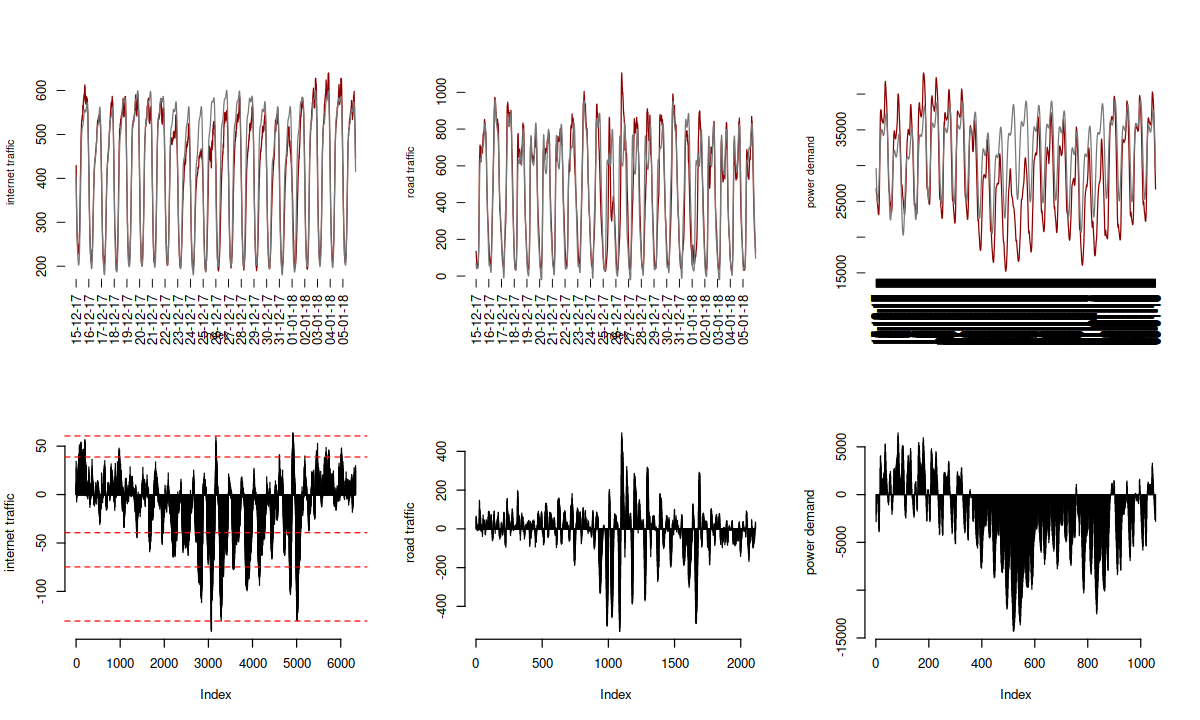

In [51]:
plot_event_closeup(as.Date("2017-12-25") - 10, as.Date("2017-12-26") + 10, daily=F)

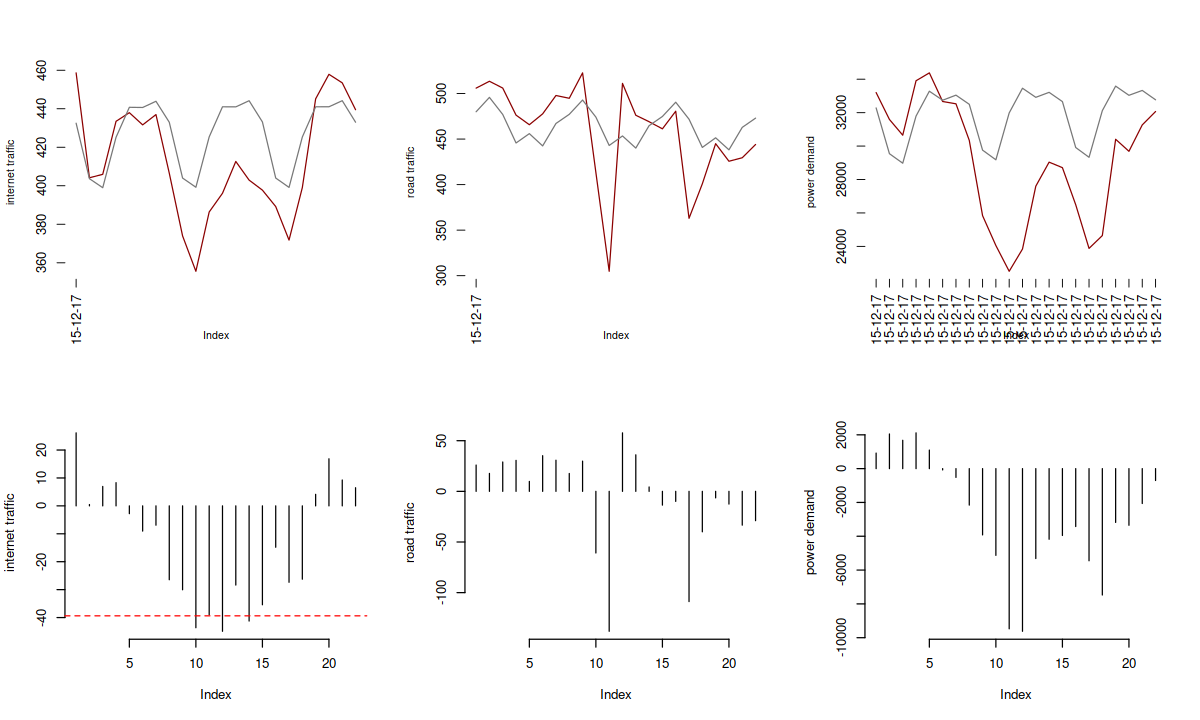

In [52]:
plot_event_closeup(as.Date("2017-12-25") - 10, as.Date("2017-12-26") + 10, daily=T)

#### new years eve 2017/2018

* internet lower before 12, higher after (skype etc?). start of day offset somewhat. lower all day next.
* road has early morning blip, then lower until later afternoon.

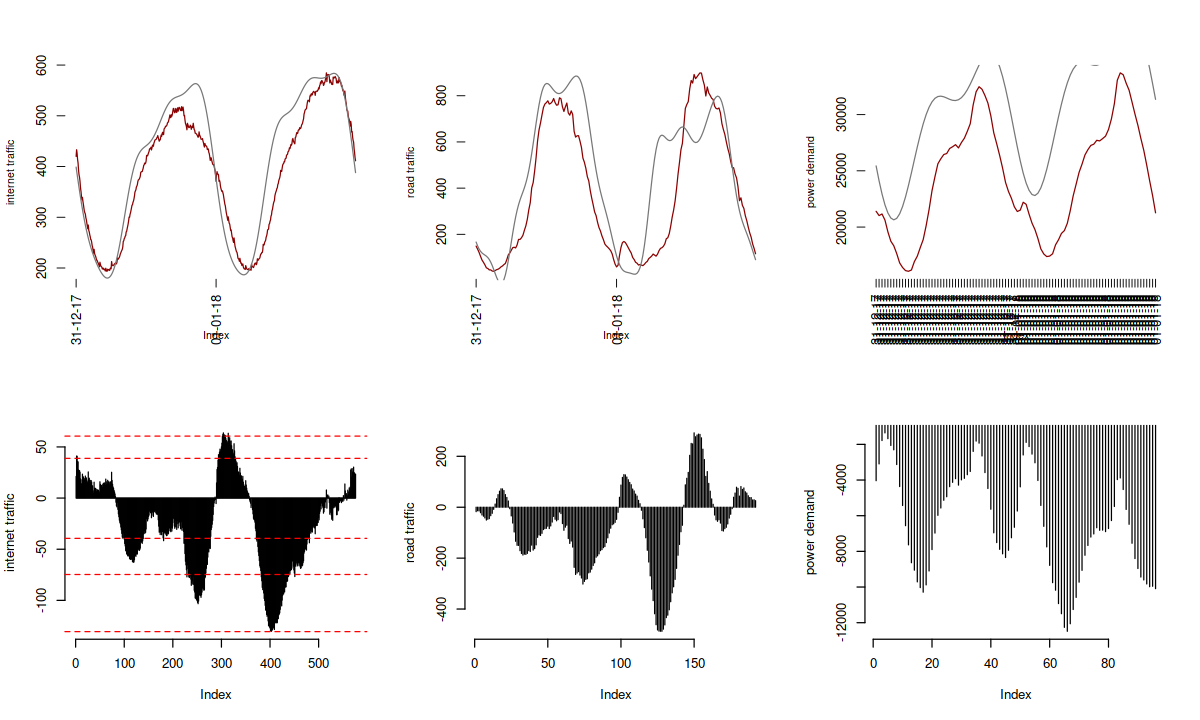

In [53]:
plot_event_closeup(as.Date("2017-12-31"), as.Date("2018-01-01"), daily=F)

#### early may bank holiday

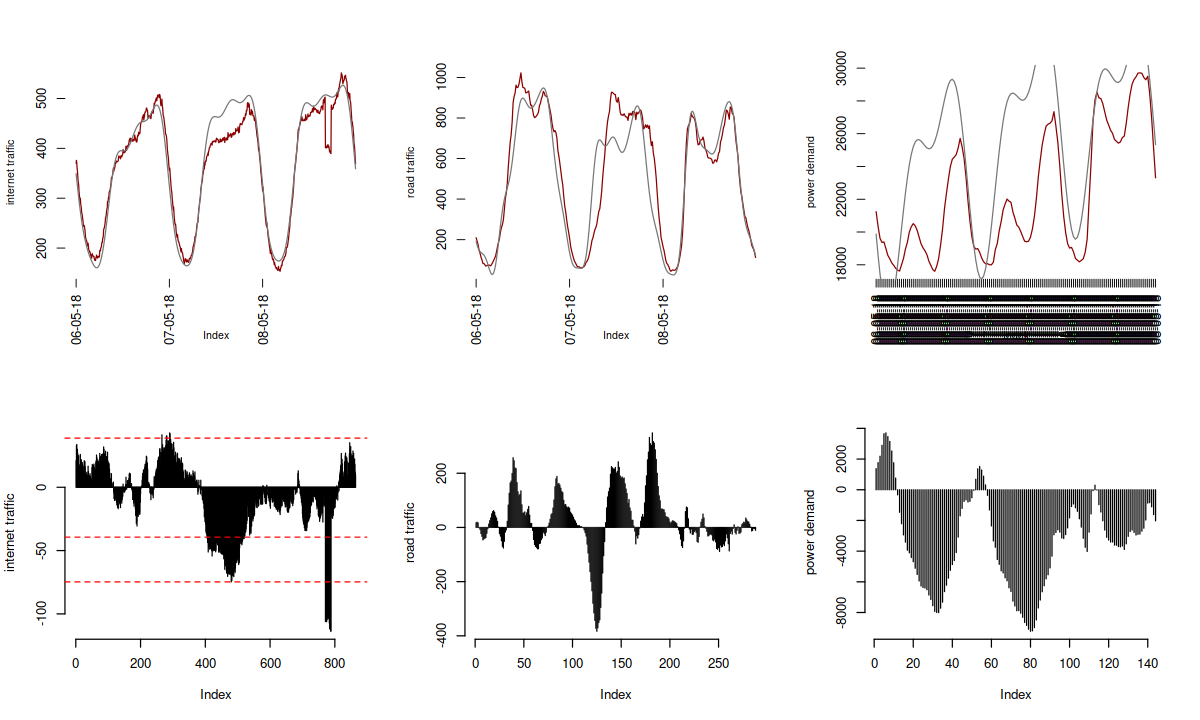

In [54]:
plot_event_closeup(as.Date("2018-05-07")-1 , as.Date("2018-05-07")+1 , daily=F)

#### 28th may 2018

* no effect in internet (only one)

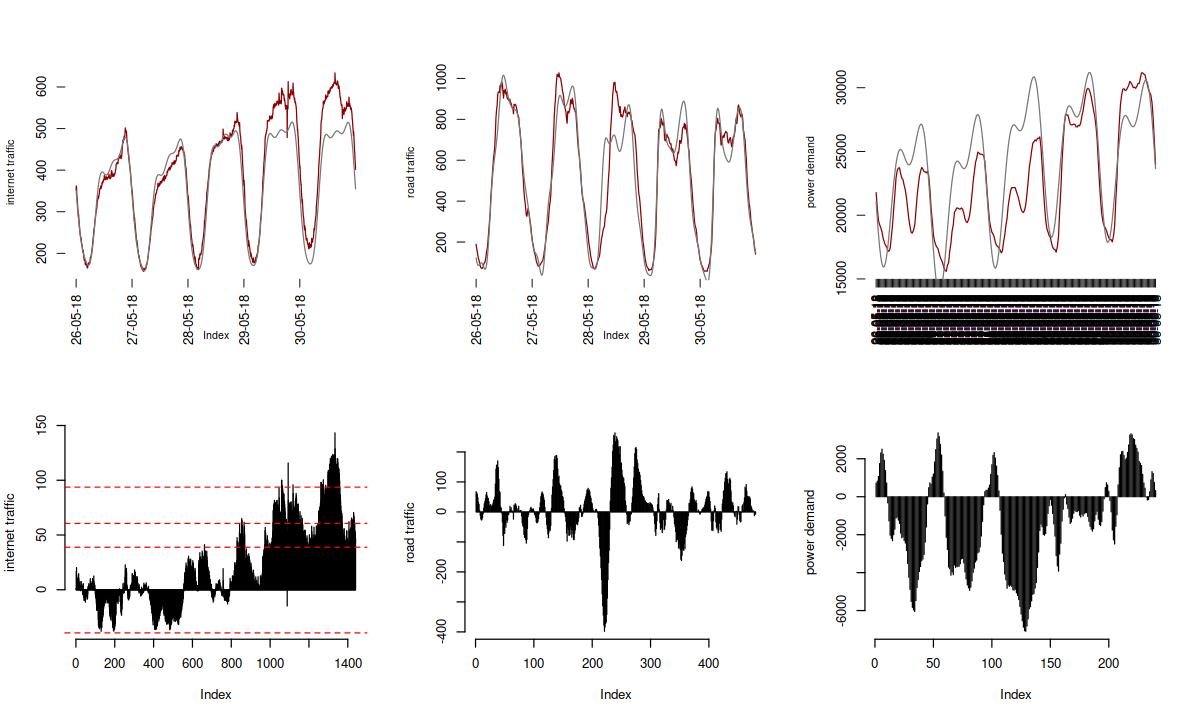

In [55]:
plot_event_closeup(as.Date("2018-05-28")-2 , as.Date("2018-05-28")+2 , daily=F)

#### summer bank holiday

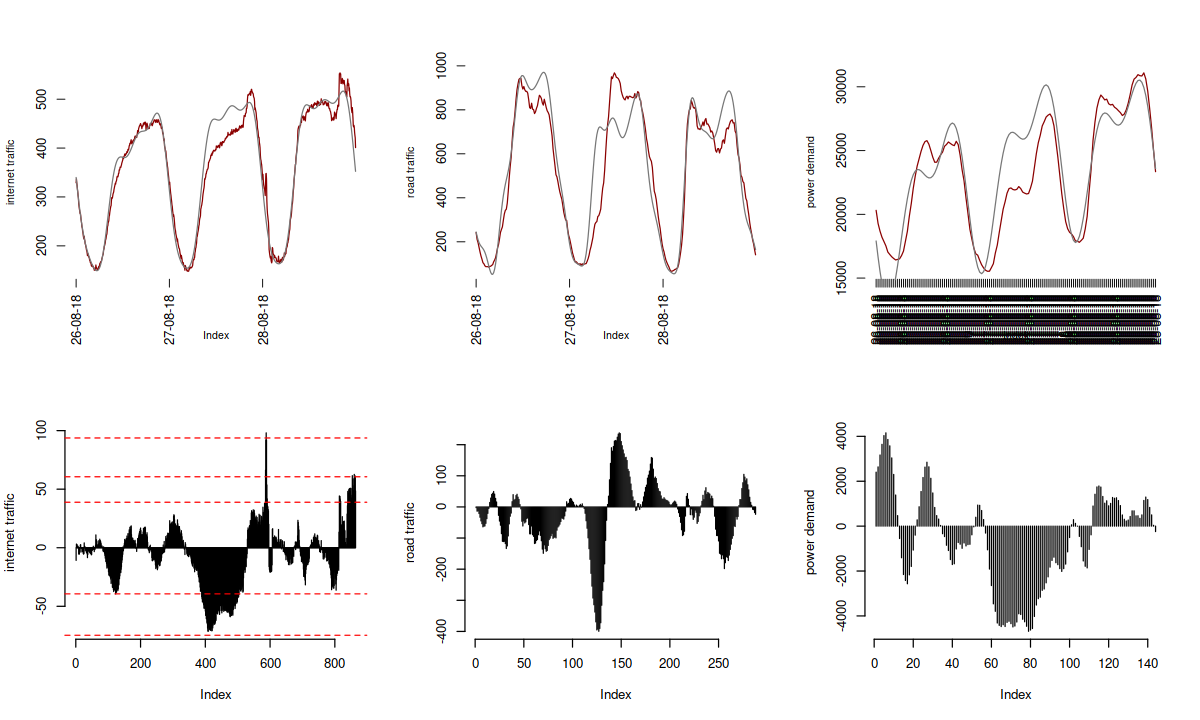

In [56]:
plot_event_closeup(as.Date("2018-08-27")-1 , as.Date("2018-08-27")+1 , daily=F)

#### all

* perhaps the residual is indicative of the % traffic usually associated with work related data use?
* is there is a trend in the residual?

In [57]:
holidays <- as.Date(c("2016-01-01", "2016-03-25", "2016-03-28", "2016-05-02", "2016-05-30", "2016-08-29", "2016-12-26", "2016-12-27",
                      "2017-01-02", "2017-04-14", "2017-04-17", "2017-05-01", "2017-05-29", "2017-08-28", "2017-12-25", "2017-12-26",
                      "2018-01-01", "2018-03-30", "2018-04-02", "2018-05-07", "2018-05-28", "2018-08-27", "2018-12-25", "2018-12-26"), tz="UTC")

internet.holidays <- internet.daily[as.Date(internet.daily$date, tz="UTC") %in% holidays, ]
mean.res <- as.vector(tapply(100*(internet.holidays$bw - internet.holidays$mean_model) / internet.holidays$bw, as.Date(internet.holidays$date, tz="UTC"), mean))
mean.res.matrix <- matrix(mean.res, ncol=8, byrow=T)
colnames(mean.res.matrix) <- c("New years day", "Good friday", "Easter monday", "May", "Spring", "Summer", "Christmas day", "Boxing day")
mean.res.matrix <- t(mean.res.matrix)
colnames(mean.res.matrix) <- c("2016", "2017", "2018")
mean.res.matrix

2016       2017       2018      
New years day         NA  -9.000620  -6.051816
Good friday    -1.945840  -6.391508 -12.056633
Easter monday  -2.331218  -8.044507  -9.928712
May            -2.528283  -1.098121  -5.980738
Spring        -11.260796  -4.249794   3.866590
Summer         -4.917647  -4.165611  -5.037597
Christmas day -10.222098  -8.854755 -22.407311
Boxing day    -15.815396 -10.195345 -22.204727

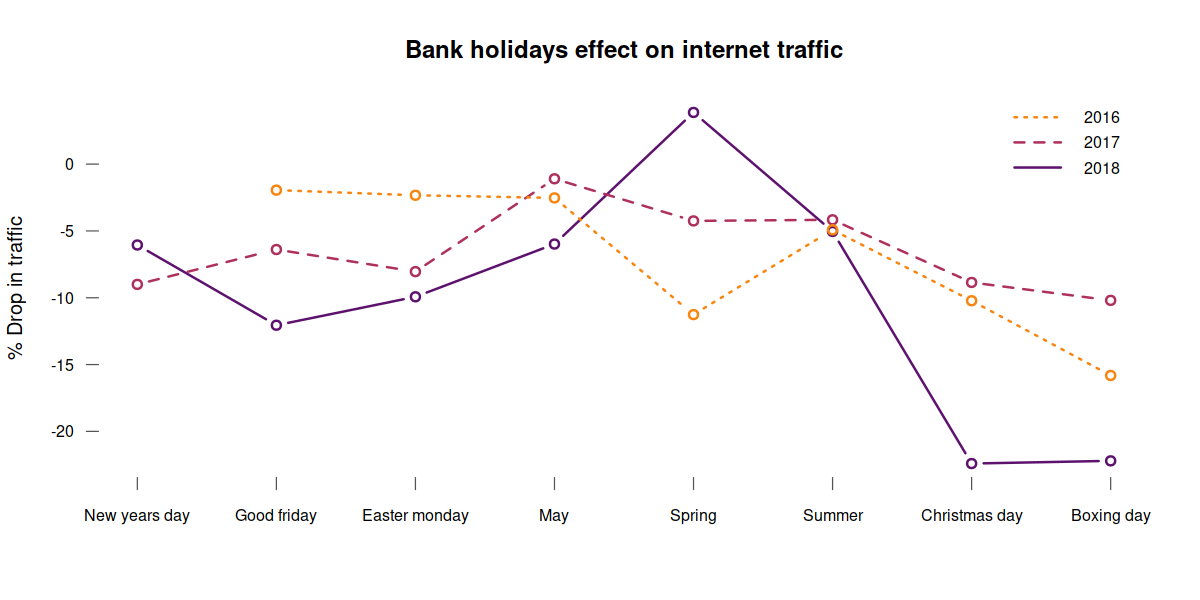

In [58]:
options(repr.plot.width=10, repr.plot.height=5)
par(bty="n", col.main="#000000", cex.axis=0.8)
#matplot(mean.res.matrix, type="l", xlab="bank holiday", ylab="% deviation from expected")
#legend("topright", colnames(mean.res.matrix),col=seq_len(3),cex=0.8,fill=seq_len(3))
plot(mean.res.matrix[, 3], lwd=2, type="b", axes=F, xlab=NA, ylab="% Drop in traffic", main="Bank holidays effect on internet traffic", col="#5d126e")
#abline(h=0, col="black", lwd=0.25)
lines(mean.res.matrix[, 2], lty=2, type="b", col="#ae305c", lwd=2)
lines(mean.res.matrix[, 1], lty=3, type="b", col="#f8850f", lwd=2)
axis(1, at=1:8, labels=rownames(mean.res.matrix), las=1, lwd=0, lwd.ticks=1, col="#555555")
axis(2, at=seq(-25, 5, 5), las=2, lwd=0, lwd.ticks=1, col="#555555")
legend("topright", colnames(mean.res.matrix),lty=rev(1:3), lwd=2, cex=0.8, col=c("#f8850f", "#ae305c", "#5d126e"), bty="n", y.intersp=2)

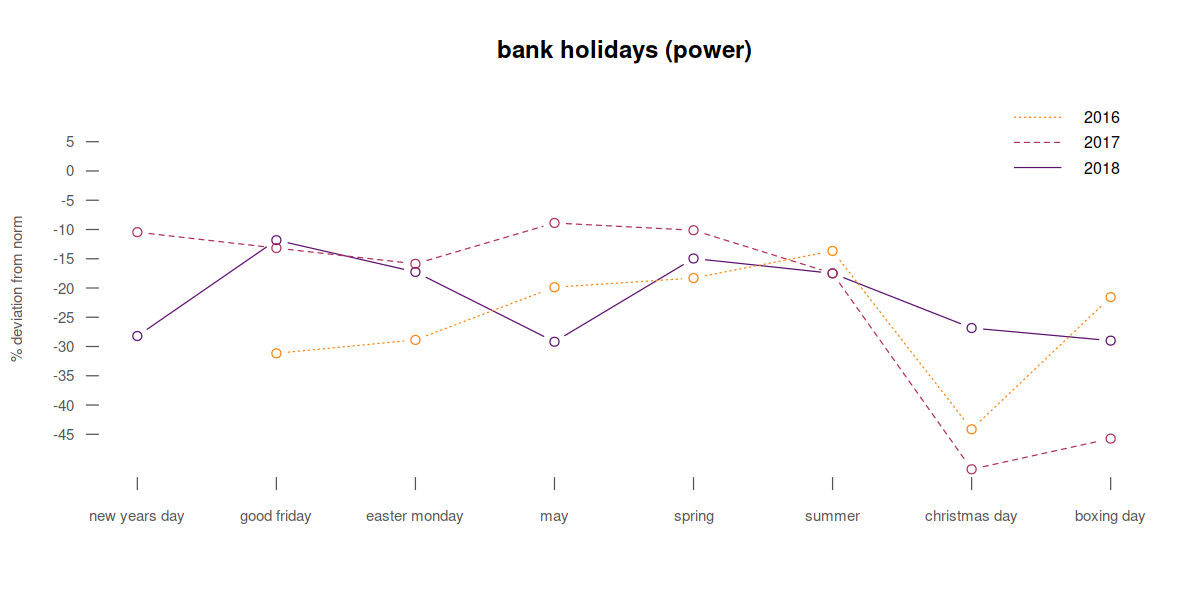

In [59]:
power.holidays <- power.daily[as.Date(power.daily$date, tz="UTC") %in% holidays, ]
power.mean.res <- as.vector(tapply(100*(power.holidays$ENGLAND_WALES_DEMAND - power.holidays$mean_model) / power.holidays$ENGLAND_WALES_DEMAND, as.Date(power.holidays$date, tz="UTC"), mean))
power.mean.res.matrix <- matrix(power.mean.res, ncol=8, byrow=T)
colnames(power.mean.res.matrix) <- c("new years day", "good friday", "easter monday", "may", "spring", "summer", "christmas day", "boxing day")
power.mean.res.matrix <- t(power.mean.res.matrix)
colnames(power.mean.res.matrix) <- c("2016", "2017", "2018")
par(bty="n", col.axis="#555555", col.lab="#555555", col.main="#000000", cex.axis=0.75, cex.lab=0.75)
#matplot(mean.res.matrix, type="l", xlab="bank holiday", ylab="% deviation from expected")
#legend("topright", colnames(mean.res.matrix),col=seq_len(3),cex=0.8,fill=seq_len(3))
plot(power.mean.res.matrix[, 3], type="b", axes=F, xlab=NA, ylab="% deviation from norm", main="bank holidays (power)", col="#5d126e", ylim=c(-50,10))
lines(power.mean.res.matrix[, 2], lty=2, type="b", col="#ae305c")
lines(power.mean.res.matrix[, 1], lty=3, type="b", col="#f8850f")
axis(1, at=1:8, labels=rownames(power.mean.res.matrix), las=1, lwd=0, lwd.ticks=1, col="#555555")
axis(2, at=seq(-45, 5, 5), las=2, lwd=0, lwd.ticks=1, col="#555555")
legend("topright", colnames(power.mean.res.matrix),lty=rev(1:3), cex=0.8, col=c("#f8850f", "#ae305c", "#5d126e"), bty="n", y.intersp=2)

#### power + internet opposite directions

In [60]:
mean.res.matrix
colMeans(mean.res.matrix, na.rm=T)
power.mean.res.matrix
colMeans(power.mean.res.matrix, na.rm=T)

2016       2017       2018      
New years day         NA  -9.000620  -6.051816
Good friday    -1.945840  -6.391508 -12.056633
Easter monday  -2.331218  -8.044507  -9.928712
May            -2.528283  -1.098121  -5.980738
Spring        -11.260796  -4.249794   3.866590
Summer         -4.917647  -4.165611  -5.037597
Christmas day -10.222098  -8.854755 -22.407311
Boxing day    -15.815396 -10.195345 -22.204727

2016      2017      2018 
-7.003040 -6.500032 -9.975118

2016      2017       2018     
new years day        NA -10.462240 -28.20370
good friday   -31.16229 -13.176164 -11.82556
easter monday -28.86939 -15.867197 -17.26062
may           -19.86813  -8.888834 -29.18544
spring        -18.30003 -10.127335 -14.95718
summer        -13.65953 -17.495238 -17.49621
christmas day -44.14693 -50.975786 -26.83912
boxing day    -21.55691 -45.735573 -28.99502

2016      2017      2018 
-25.36617 -21.59105 -21.84536

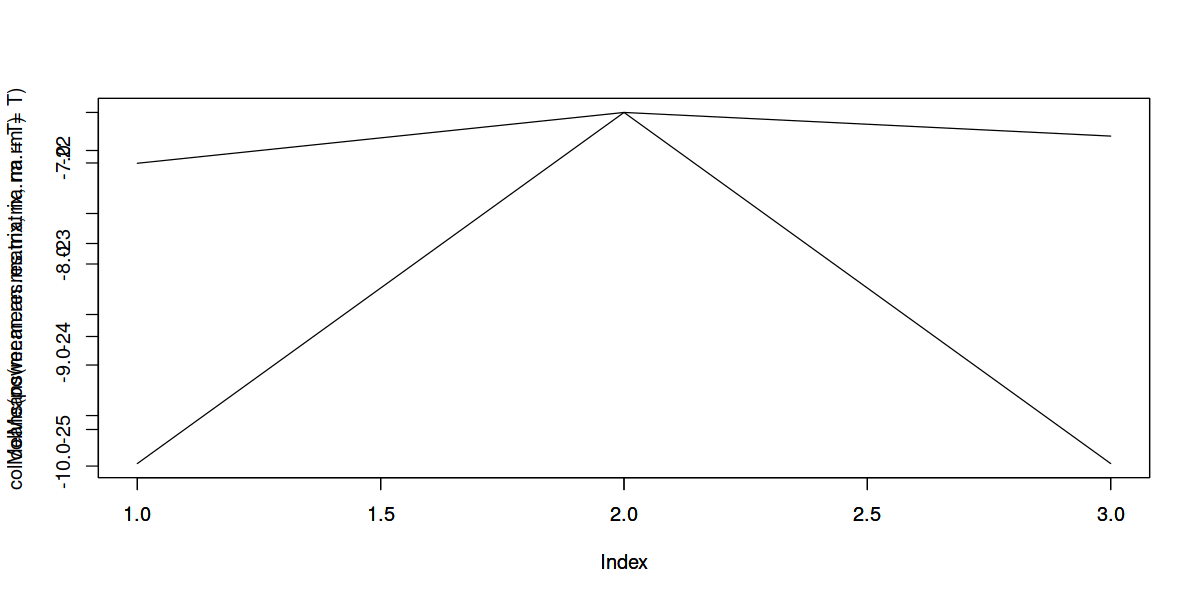

In [61]:
# on average, each year -negative correlation (just 3 samples)
plot(colMeans(power.mean.res.matrix, na.rm=T), type="l")
par(new=T)
plot(colMeans(mean.res.matrix, na.rm=T), type="l")

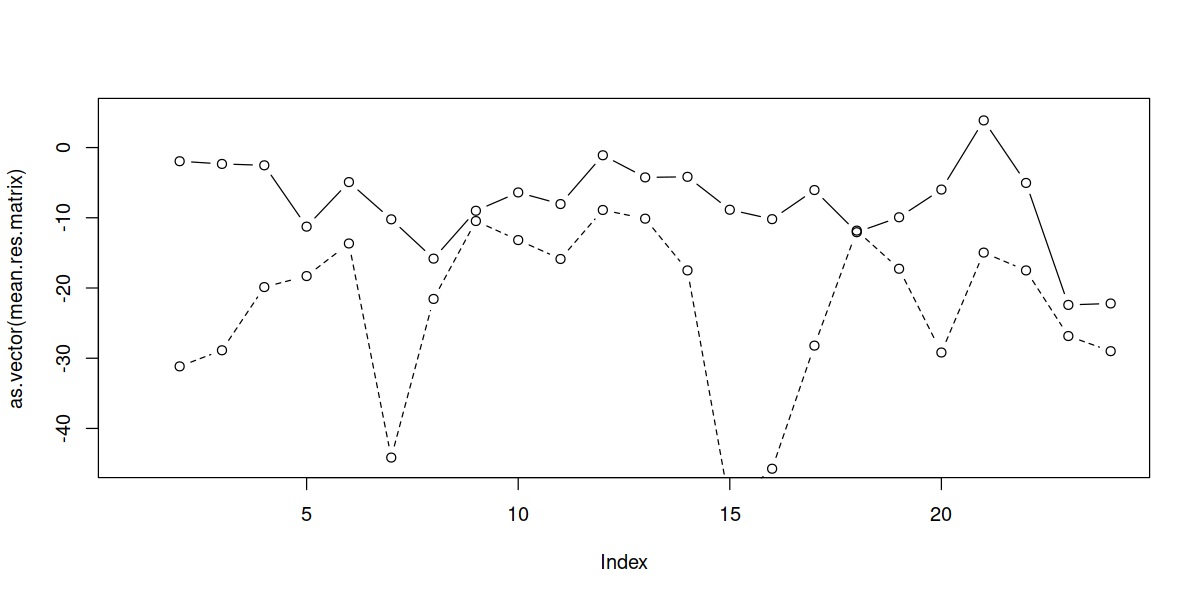

In [62]:
# unrolled
plot(as.vector(mean.res.matrix), ylim=c(-45,5), type="b")
lines(as.vector(power.mean.res.matrix), type="b", lty=2)

In [63]:
sort(rowMeans(mean.res.matrix))

Boxing day Christmas day   Good friday Easter monday        Summer 
   -16.071823    -13.828054     -6.797994     -6.768146     -4.706952 
       Spring           May 
    -3.881333     -3.202381

In [64]:
sort(rowMeans(power.mean.res.matrix))

christmas day    boxing day easter monday           may   good friday 
    -40.65395     -32.09583     -20.66574     -19.31414     -18.72134 
       summer        spring 
    -16.21699     -14.46151

In [65]:
cor.test(rowMeans(mean.res.matrix), rowMeans(power.mean.res.matrix), method="kendall")


	Kendall's rank correlation tau

data:  rowMeans(mean.res.matrix) and rowMeans(power.mean.res.matrix)
T = 16, p-value = 0.1361
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.5238095 


In [66]:
lapply(c("2016", "2017", "2018"), function(x) cor(mean.res.matrix[, x], power.mean.res.matrix[, x], method="kendall"))

[[1]]
[1] NA

[[2]]
[1] 0.4285714

[[3]]
[1] 0.07142857

### political events

#### 23 june 2016 eu referendum, 24 june result

* internet: bit lower on polling day (esp in morning and post work), higher for period after polling closes until next evening.
* road: lower on polling day (all day)
* power: higher on polling day.

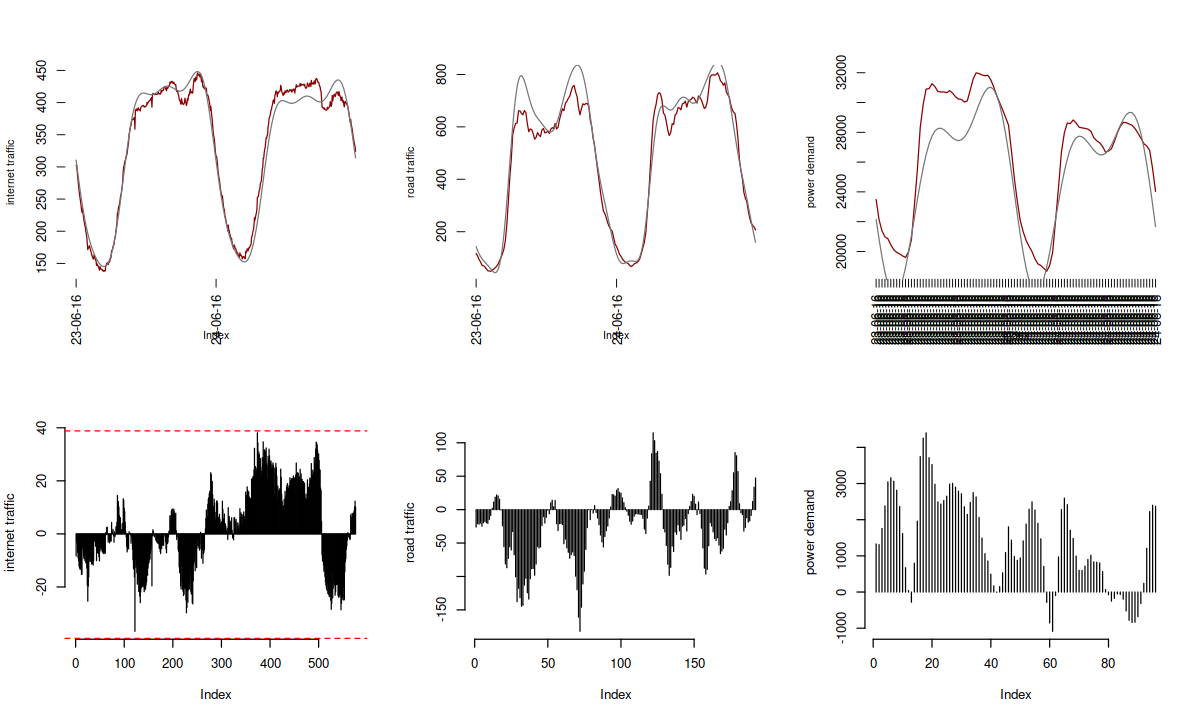

In [67]:
plot_event_closeup(as.Date("2016-06-23"), as.Date("2016-06-24") , daily=F)

#### general election 2017

* internet: lower all day then above expected in early hours of morning. however the low continues for another 14 days.

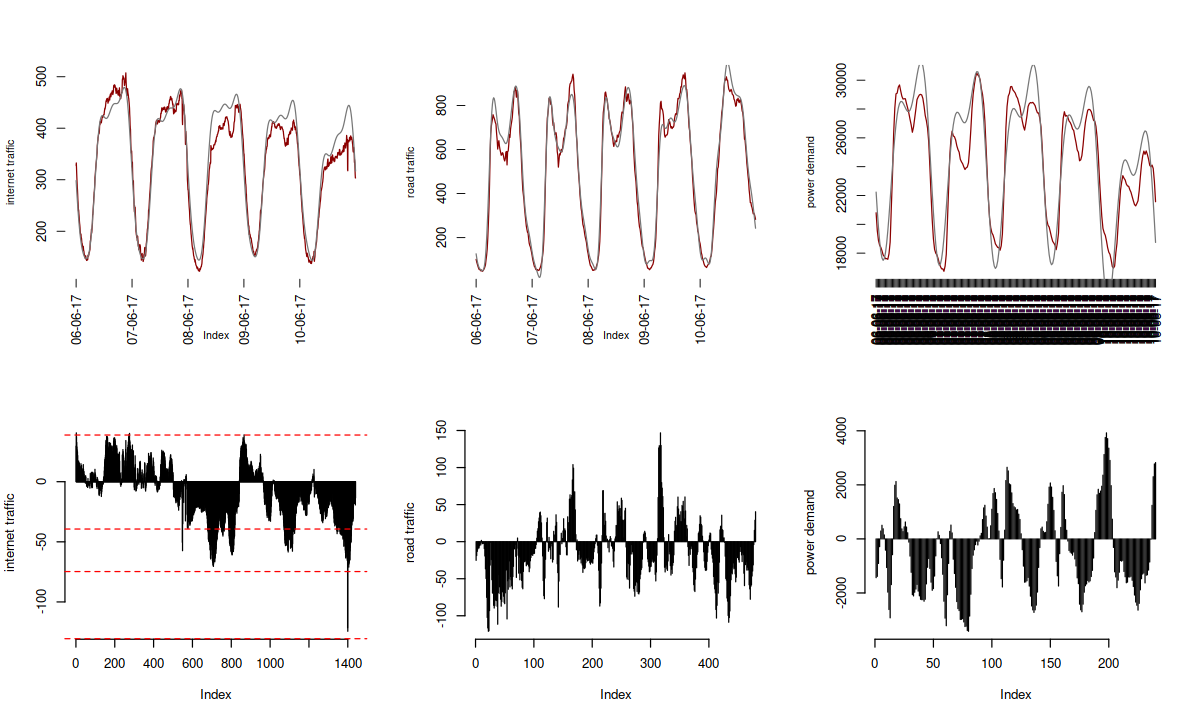

In [68]:
plot_event_closeup(as.Date("2017-06-08")-2, as.Date("2017-06-08")+2 , daily=F)

#### sporting events

##### england vs panama
* half time: 13:50
* internet: higher during game

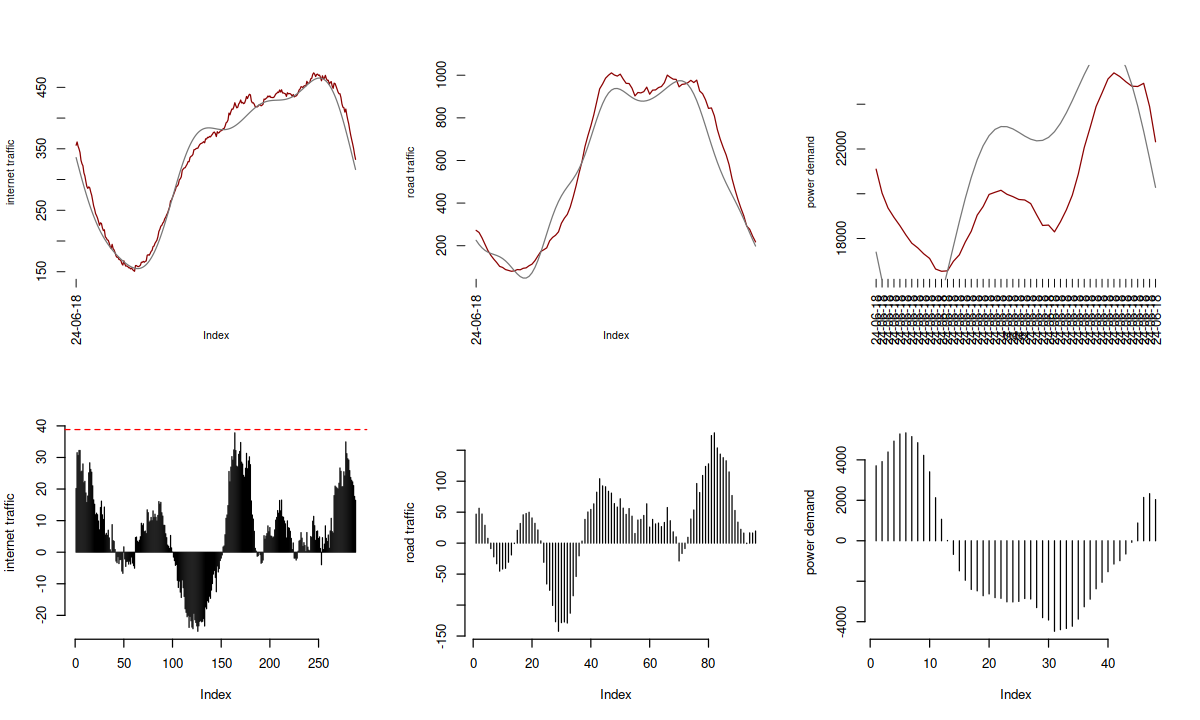

In [69]:
plot_event_closeup(as.Date("2018-06-24"), as.Date("2018-06-24") , daily=F)

#### england vs columbia penalty shootout
* watched by 23.6 million viewers
* internet: obvious peak
* road: down all day

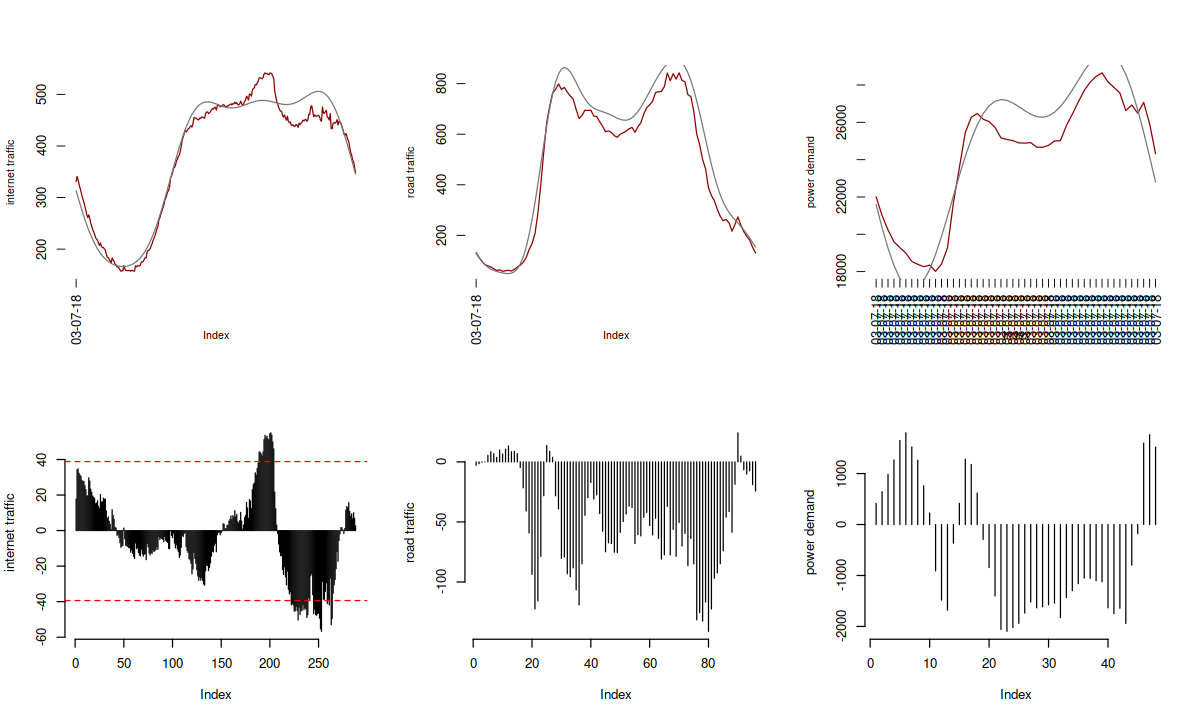

In [70]:
plot_event_closeup(as.Date("2018-07-03"), as.Date("2018-07-03") , daily=F)

#### england vs sweeden
* internet: interesting, down all day except during game where peak ooccurs
* road: dip during game.

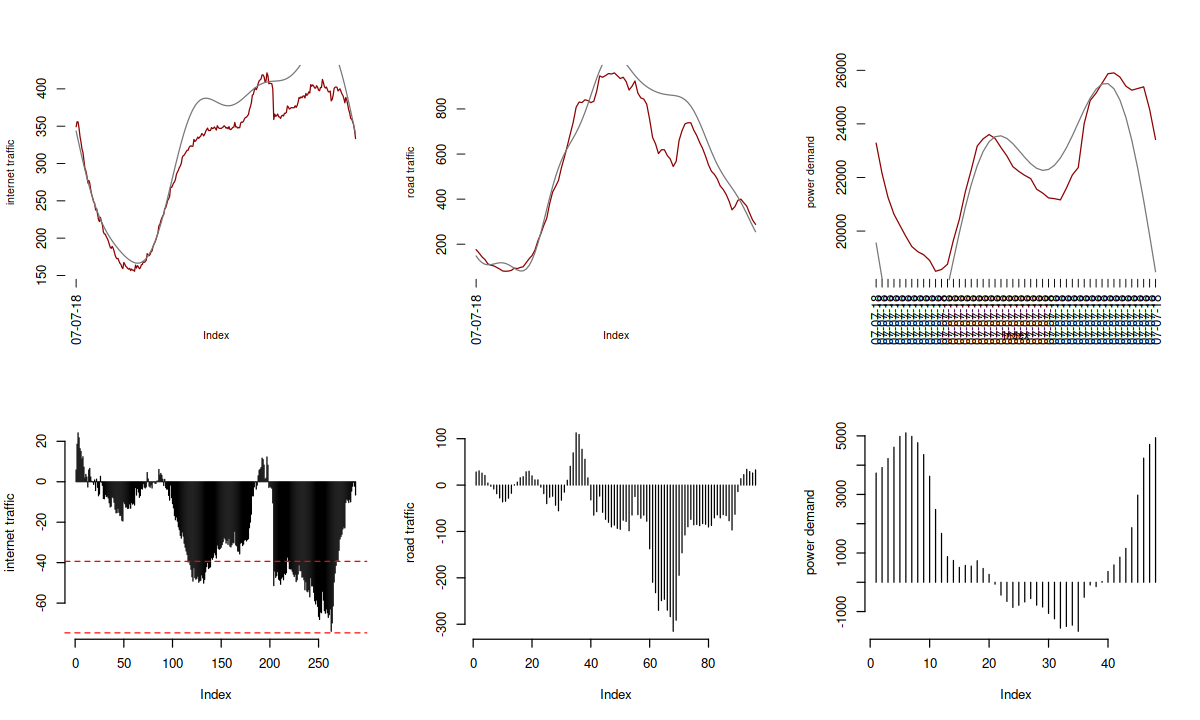

In [71]:
plot_event_closeup(as.Date("2018-07-07"), as.Date("2018-07-07") , daily=F)

#### england vs croatia
* half time: 19:50
* internet: down during that period with pickup at half time?

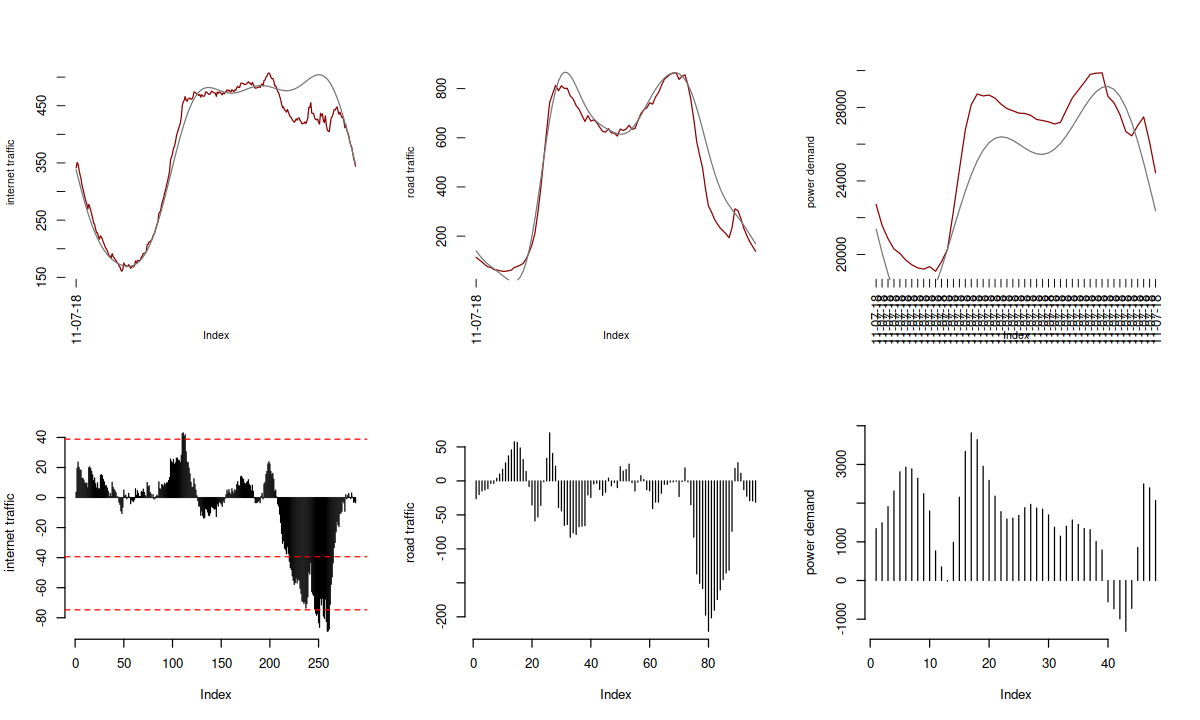

In [72]:
plot_event_closeup(as.Date("2018-07-11"), as.Date("2018-07-11") , daily=F)

#### specific, non-occurring events

##### o2 network disruption

low all day with drop-outs

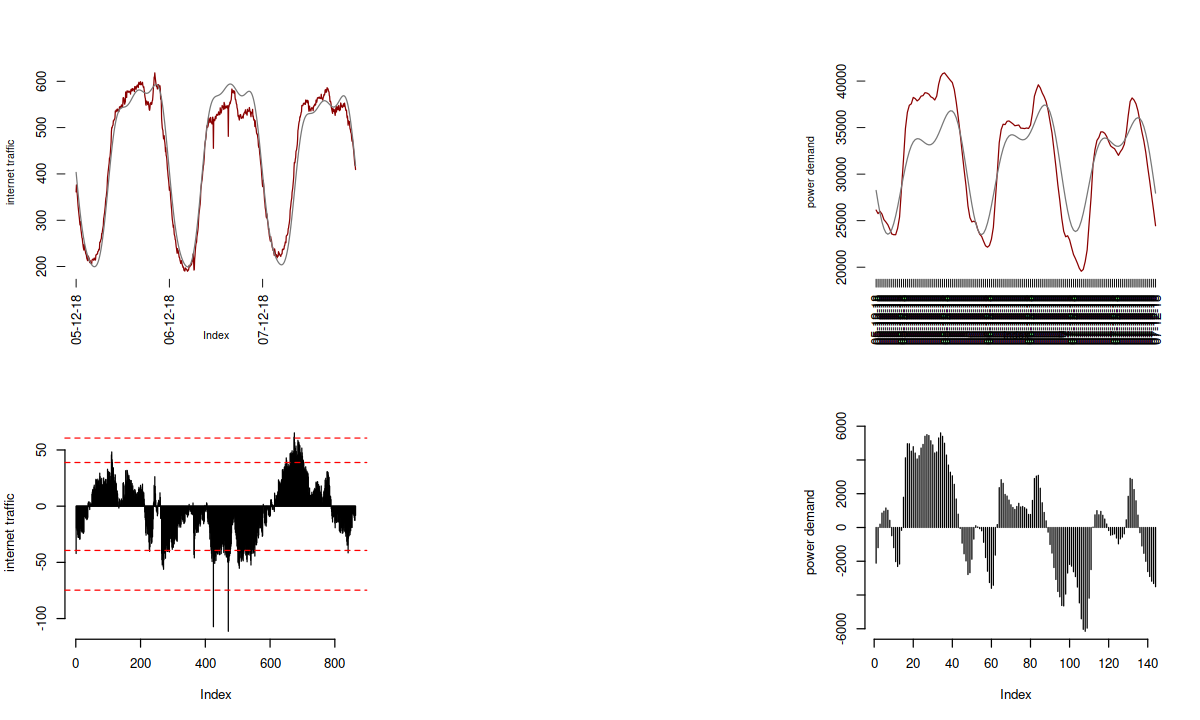

In [73]:
# no road data for this period.
plot_event_closeup(as.Date("2018-12-06")-1, as.Date("2018-12-06")+1 , daily=F)

#### 22 March 2017 westminster terror attack

* 14:40. visible in internet.

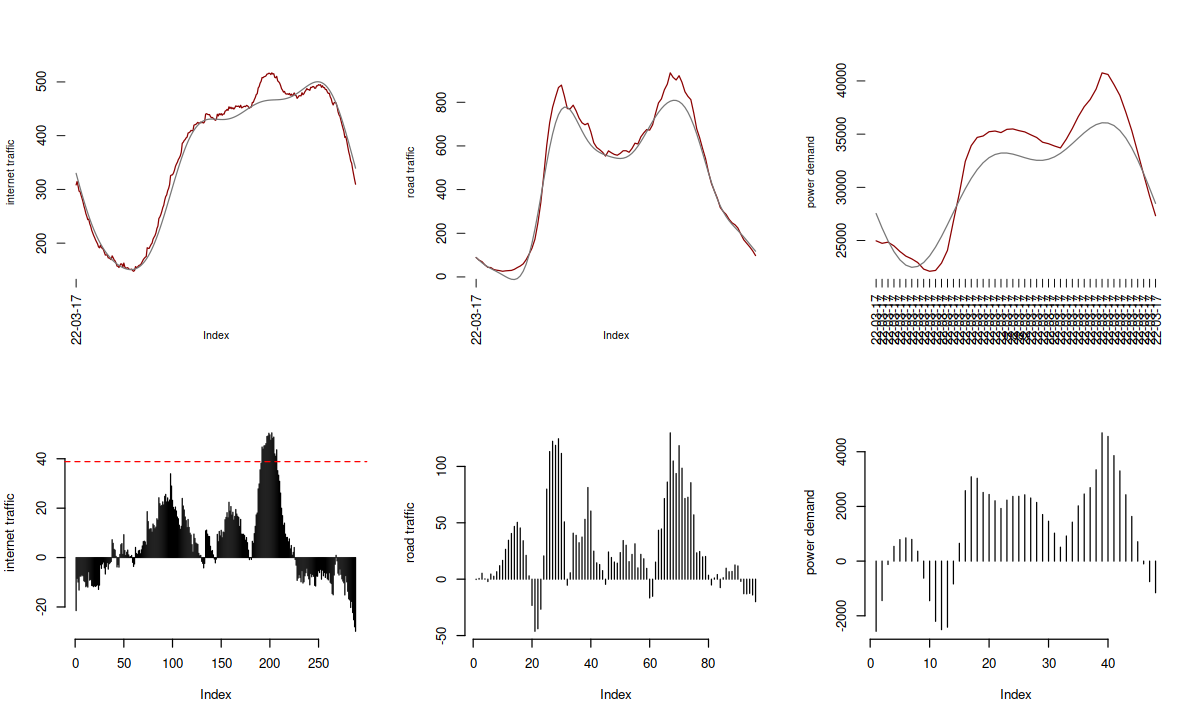

In [74]:
plot_event_closeup(as.Date("2017-03-22"), as.Date("2017-03-22") , daily=F)

## plots for presentation

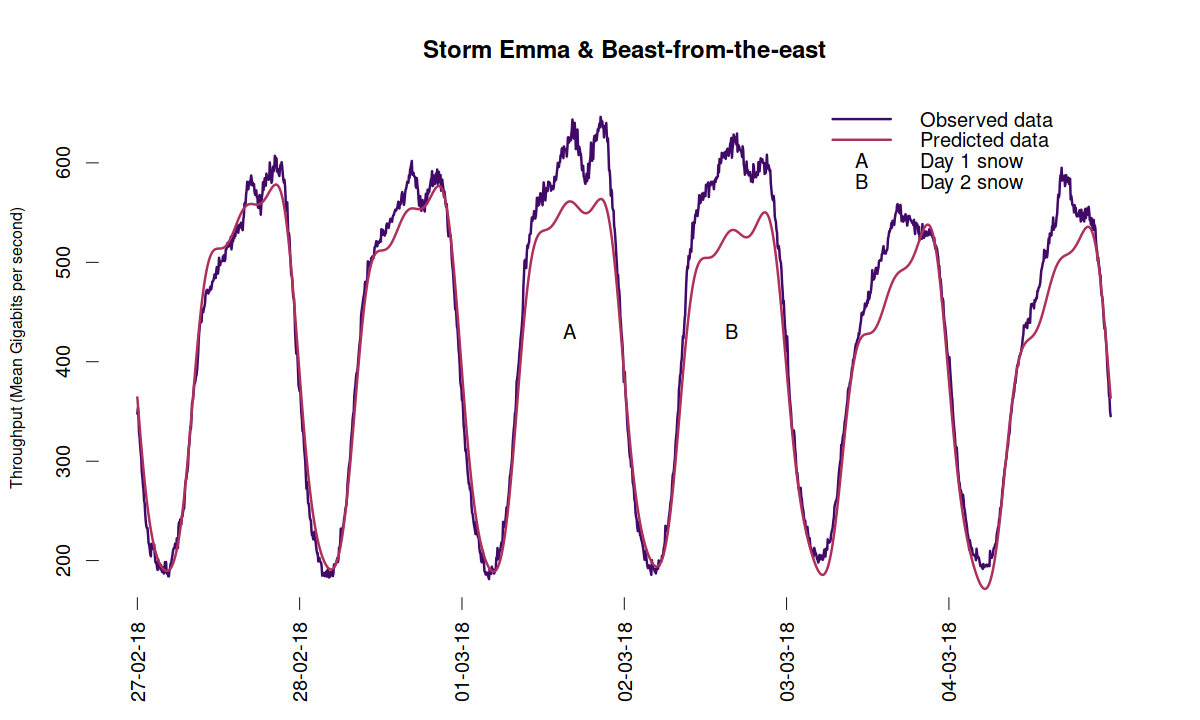

In [75]:
line.colour <- "#420a68"
ssa.model.colour <- "#ae305c"
#mew.model.colour <- "#f8850f"
ylab <- "Throughput (Mean Gigabits per second)"
main <- "Storm Emma & Beast-from-the-east"
y.name <- "bw"
from <- as.Date("2018-03-01") - 2
to <- as.Date("2018-03-02") + 2
par(bty="n")
ts <- internet.daily
ts.range <- ts[ts$date >= from & ts$date <= to, ]
dates <- strftime(unique(ts.range$date), "%d-%m-%y")
date.idx <- which(!duplicated(ts.range$date)) # first occurrance of date.
series <- ts.range[, y.name]
plot(series, type="l", lwd=2, col=line.colour, cex.lab=0.8, axes=F, xlab="", ylab=ylab, main=main)
lines(ts.range$model, col=ssa.model.colour, lty=1, lwd=2)
#lines(ts.range$mean_model, col=mew.model.colour, lty=2)
axis(1, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=2, at=date.idx, labels=dates)
axis(2, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1)
legend("topright",
  legend = c("Observed data", "Predicted data", "Day 1 snow", "Day 2 snow"),
  col = c(line.colour, ssa.model.colour, "#000000", "#000000"), 
  lty=c(1, 1, NA, NA),
  lwd=c(2, 2, NA, NA),
  pch=c(NA, NA, "A", "B"),
  bty = "n", 
  pt.cex = 1, 
  cex = 1, 
  horiz = F , 
  inset = c(0, 0))
text(288*2 + 192, mean(series), "A")
text(288*3 + 192, mean(series), "B")

In [76]:
res_plot <- function(main, q, from, to, lwd=2, ...) {
    line.colour <- "#420a68"
    ssa.model.colour <- "#ae305c"
    ylab <- "Residual throughput (Mean Gigabits per second)"
    par(bty="n", mar=c(5,5,1,5))
    ts <- internet.daily
    ts.range <- ts[ts$date >= from & ts$date <= to, ]
    if(to-from > 1) {
        dates <- strftime(unique(ts.range$date), "%d-%m-%y")
        date.idx <- which(!duplicated(ts.range$date)) # first occurrance of date.
    } else {
        dates <- c(0:23, NA)
        date.idx <- seq(0, 288, 12)
    }
    series <- ts.range$bw - ts.range$model
    plot(series, type="h", lwd=lwd, col=line.colour, cex.lab=0.8, axes=F, xlab="", ylab=ylab, main=main,
         panel.first=abline(h=q, col=c("#ed6925"), lty=2, lwd=1), ...)
    axis(1, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, las=2, at=date.idx, labels=dates)
    axis(2, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1)
    axis(2, side=4, tick=T, lwd=0, lwd.ticks=0.75, cex.axis=1, at=q, labels=names(q))
    mtext("Residual percentile (rarity)", side=4, line=4, cex = 0.8)
}

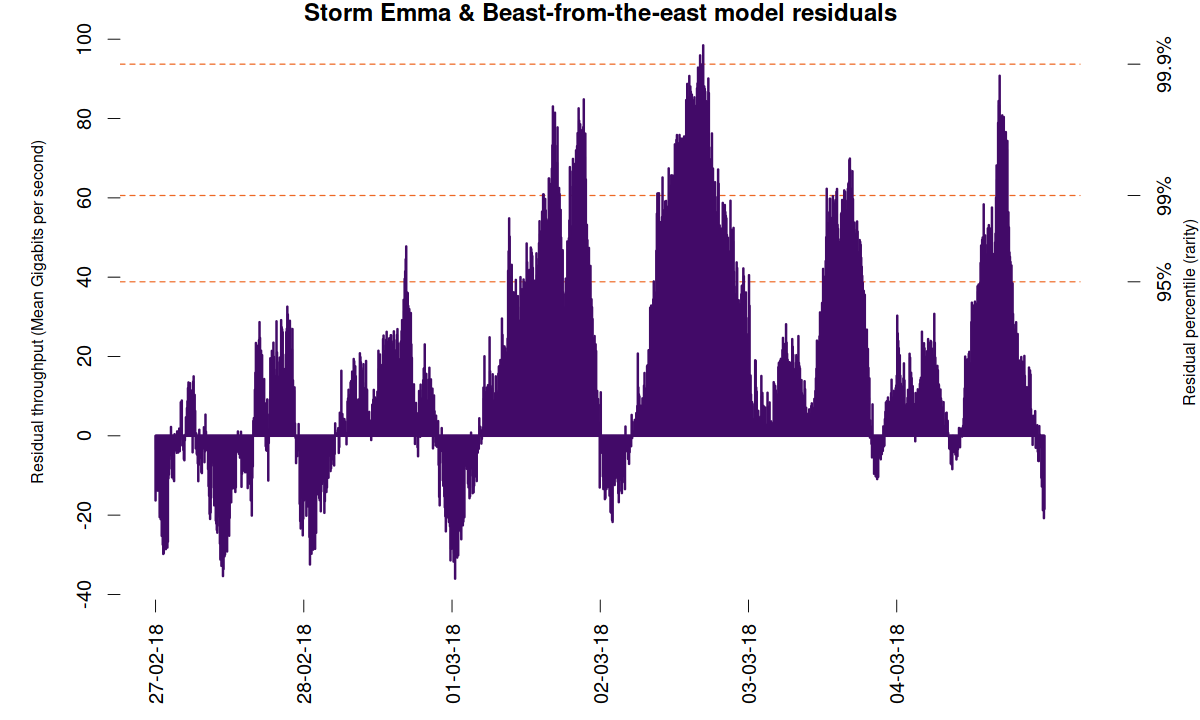

In [77]:
res_plot("Storm Emma & Beast-from-the-east model residuals", quants[4:6], as.Date("2018-03-01") - 2, as.Date("2018-03-02") + 2)
text(288*2 + 192, mean(series), "A", col="#ffffff")
text(288*3 + 192, mean(series), "B", col="#ffffff")

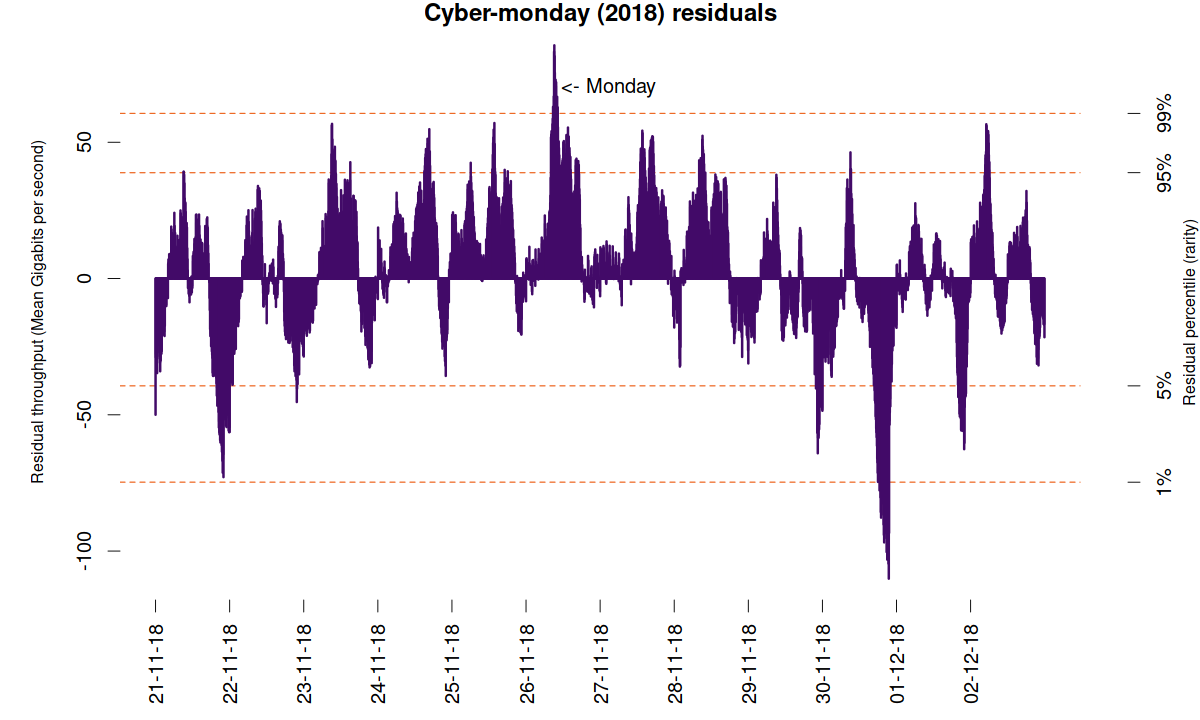

In [78]:
res_plot("Cyber-monday (2018) residuals", quants[2:5], as.Date("2018-11-23") - 2, as.Date("2018-11-30") + 2)
text(288*5 + 320, 70, "<- Monday")

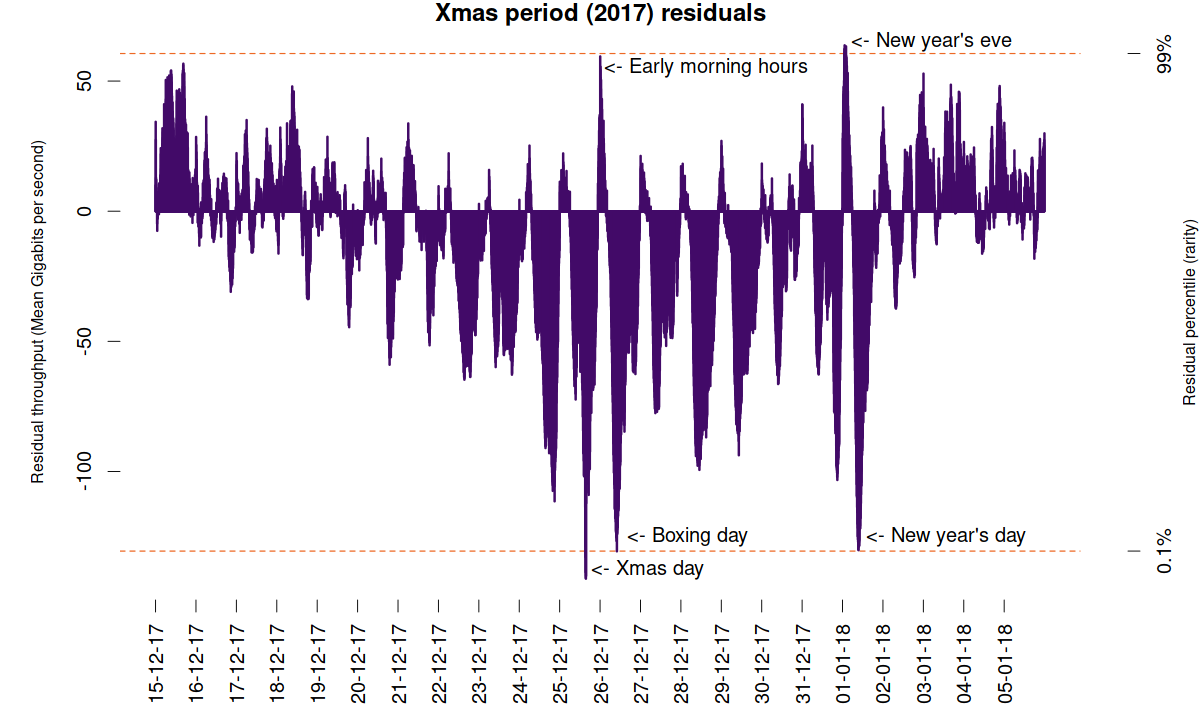

In [79]:
res_plot("Xmas period (2017) residuals", quants[c(1,5)], as.Date("2017-12-25") - 10, as.Date("2017-12-26") + 10)
text(288*12 + 50, -138, "<- Xmas day")
text(288*13 + 180, 55, "<- Early morning hours")
text(288*13 + 50, -125, "<- Boxing day")
text(288*18 + 350, 65, "<- New year's eve")
text(288*18 + 450, -125, "<- New year's day")

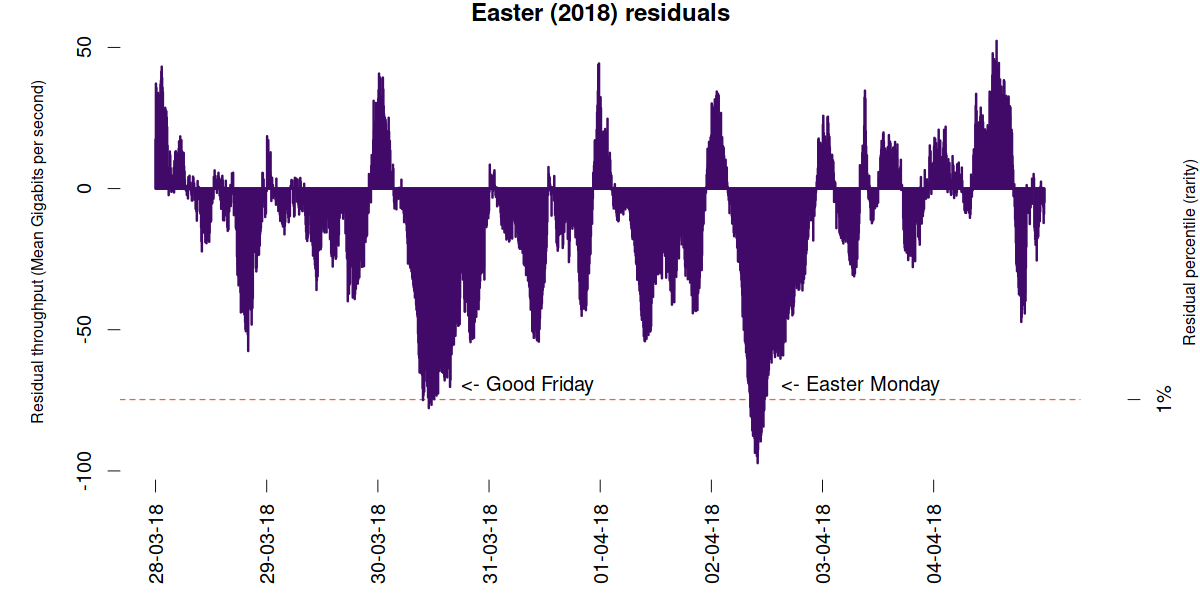

In [146]:
options(repr.plot.width=10, repr.plot.height=5)
res_plot("Easter (2018) residuals", quants[2], as.Date("2018-03-30") - 2, as.Date("2018-04-02") + 2)
text(288*3 + 100, -70, "<- Good Friday")
text(288*6 + 100, -70, "<- Easter Monday")

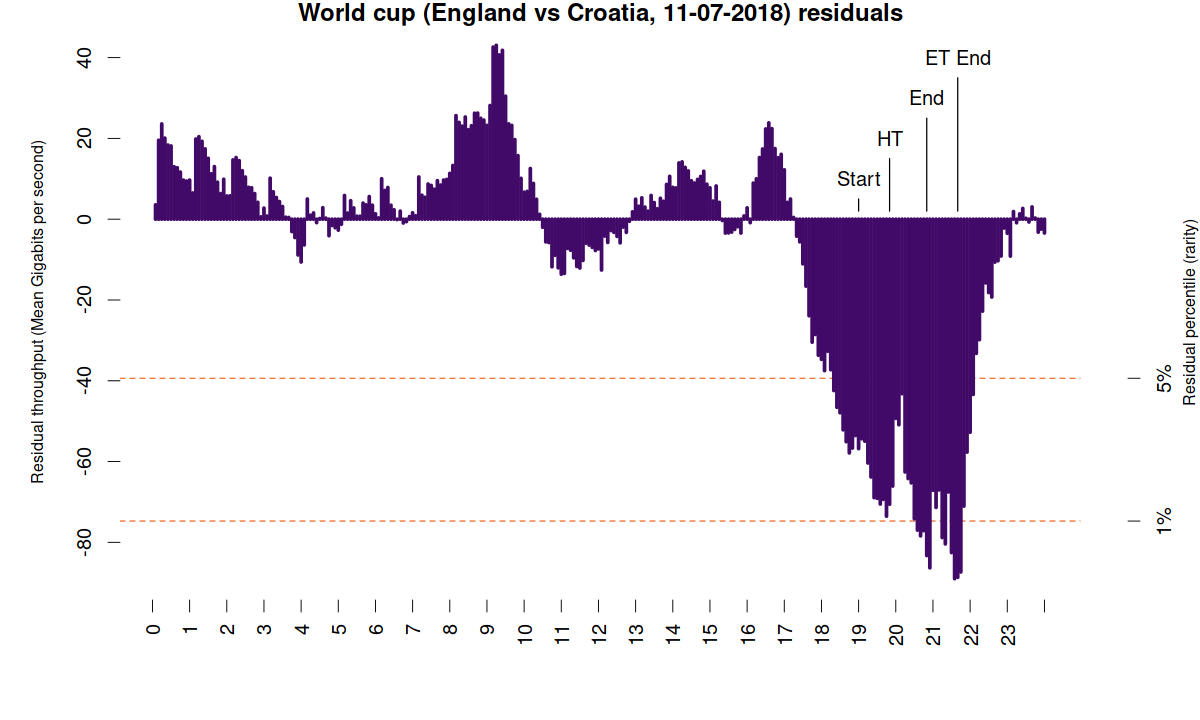

In [80]:
res_plot("World cup (England vs Croatia, 11-07-2018) residuals", quants[2:3], as.Date("2018-07-11"), as.Date("2018-07-11"), lwd=3)

segments(228, 2, 228, 5)
segments(238, 2, 238, 15)
segments(250, 2, 250, 25)
segments(260, 2, 260, 35)
text(228, 10, "Start")
text(238, 20, "HT")
text(250, 30, "End")
text(260, 40, "ET End")

In [81]:
# df
#    row col    val
# 1   01 Friday 439508518239
# 2   02 Friday 448233565472
# 3   03 Friday 459150254186
# 4   04 Friday 443813675876
# 5   05 Friday 471467864237
# 6   06 Friday 392934487714                    
weekly_heatmap <- function(df, year, col.scheme="inferno", border=NA, title="") {
  g <- ggplot(df, aes(x=row, y=col))
  g <- g + geom_tile(aes(fill=val), col="#000000") + scale_fill_viridis(option=col.scheme)
  g <- g + guides(fill=F) + theme(axis.title.y=element_blank(),
                                  axis.title.x=element_blank(),
                                  text=element_text(size=10),
                                  axis.text.x = element_text(angle = 90, vjust = 0.5),
                                  plot.title = element_text(hjust = 1))
  g <- g + theme(panel.background=element_rect(fill="#ffffff"))
  g <- g + ggtitle(title)
  g
}

In [115]:
nrow(drawdowns)
drawdowns$date <- as.Date(drawdowns$date, tz="UTC")
# calendar weeks are monday to sunday.
drawdowns$day <- factor(weekdays(drawdowns$date), levels=rev(c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")))
drawdowns$woy <- strftime(drawdowns$date, "%W")
drawdowns$year <- strftime(drawdowns$date, "%Y")
head(drawdowns)

[1] 1096

date       d999 d99 d95 mew       day       woy year
2016-01-01 2016-01-01 3    51  80  -9.097272 Friday    00  2016
2016-01-02 2016-01-02 3    19  54  24.952439 Saturday  00  2016
2016-01-03 2016-01-03 2    34  65  37.809871 Sunday    00  2016
2016-01-04 2016-01-04 0     4  36  28.592625 Monday    01  2016
2016-01-05 2016-01-05 0     2  45  22.214475 Tuesday   01  2016
2016-01-06 2016-01-06 0     0  48  28.812514 Wednesday 01  2016

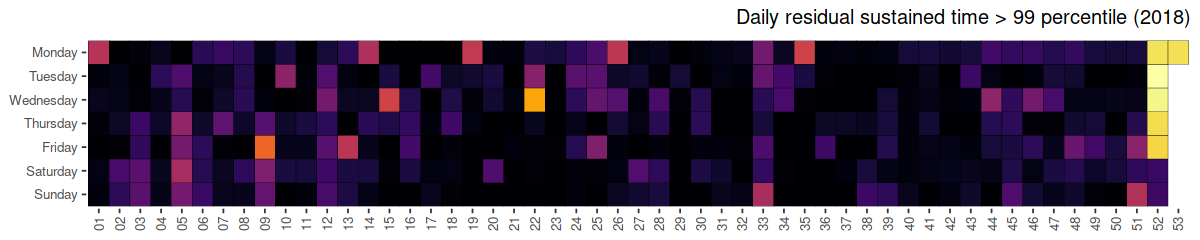

In [122]:
library(ggplot2)
library(viridis)
options(repr.plot.width=10, repr.plot.height=2)
x <- drawdowns[drawdowns$year == 2018, c("woy", "day", "d95", "year")]
x <- x[order(x$woy, x$day), ]
colnames(x) <- c("row", "col", "val")
#x$val <- abs(x$val)
weekly_heatmap(x, title="Daily residual sustained time > 99 percentile (2018)")

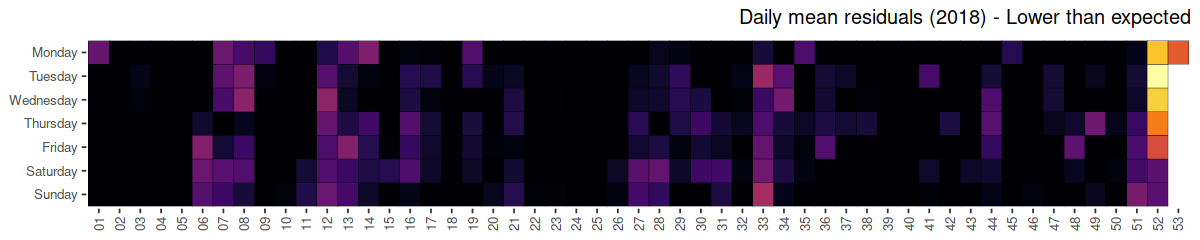

In [129]:
options(repr.plot.width=10, repr.plot.height=2)
x <- drawdowns[drawdowns$year == 2018, c("woy", "day", "mew", "year")]
x <- x[order(x$woy, x$day), ]
colnames(x) <- c("row", "col", "val")
x$val <- ifelse(x$val < 0 , abs(x$val), 0)
weekly_heatmap(x, title="Daily mean residuals (2018) - Lower than expected")

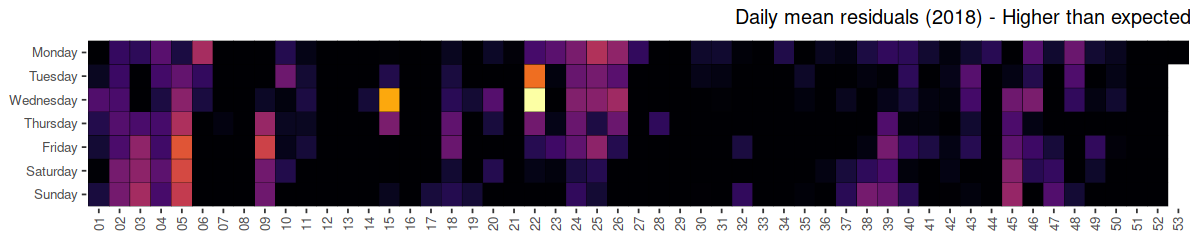

In [130]:
options(repr.plot.width=10, repr.plot.height=2)
x <- drawdowns[drawdowns$year == 2018, c("woy", "day", "mew", "year")]
x <- x[order(x$woy, x$day), ]
colnames(x) <- c("row", "col", "val")
x$val <- ifelse(x$val > 0 , abs(x$val), 0)
weekly_heatmap(x, title="Daily mean residuals (2018) - Higher than expected")

In [94]:
ts_heatmap <- function(ts, col.scheme="inferno") {
  g <- ggplot(ts, aes(x=ts$date, y=msm))
  g <- g + geom_tile(aes(fill=val)) + scale_fill_viridis(option=col.scheme)
  g <- g + guides(fill=F) + theme(axis.title.y=element_blank(),
                                  axis.title.x=element_blank(),
                                  text=element_text(size=10, family = "serif"),
                                  axis.text.x = element_text(angle = 90, vjust = 0.5),
                                  plot.title = element_text(hjust = 1),
                                  axis.text.y = element_blank())
  g
}

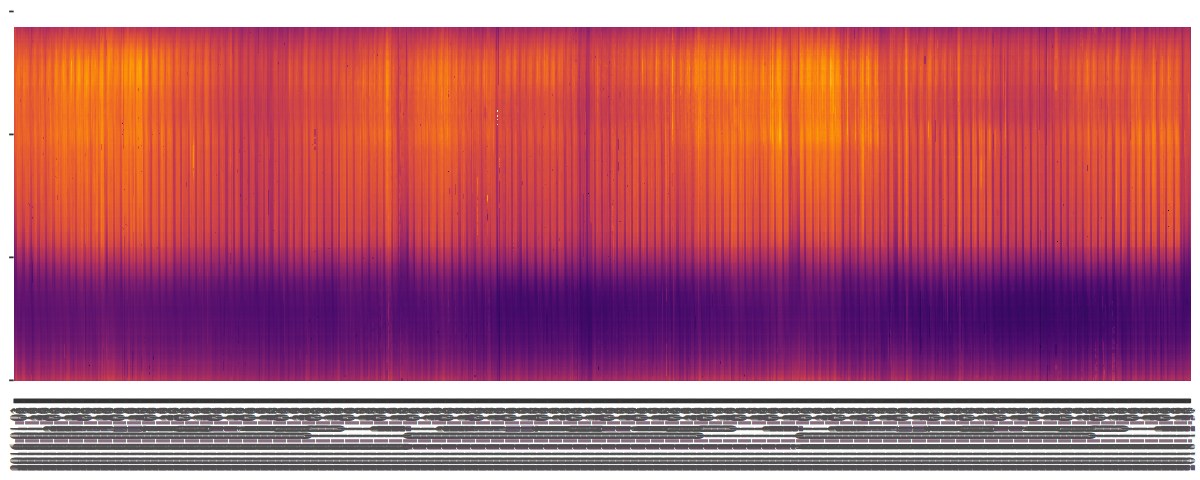

In [87]:
options(repr.plot.width=10, repr.plot.height=4)
x <- internet.daily[, c("date", "msm")]
x$val <- internet.daily$bw - internet.daily$trend
ts_heatmap(x, col.scheme = "inferno")

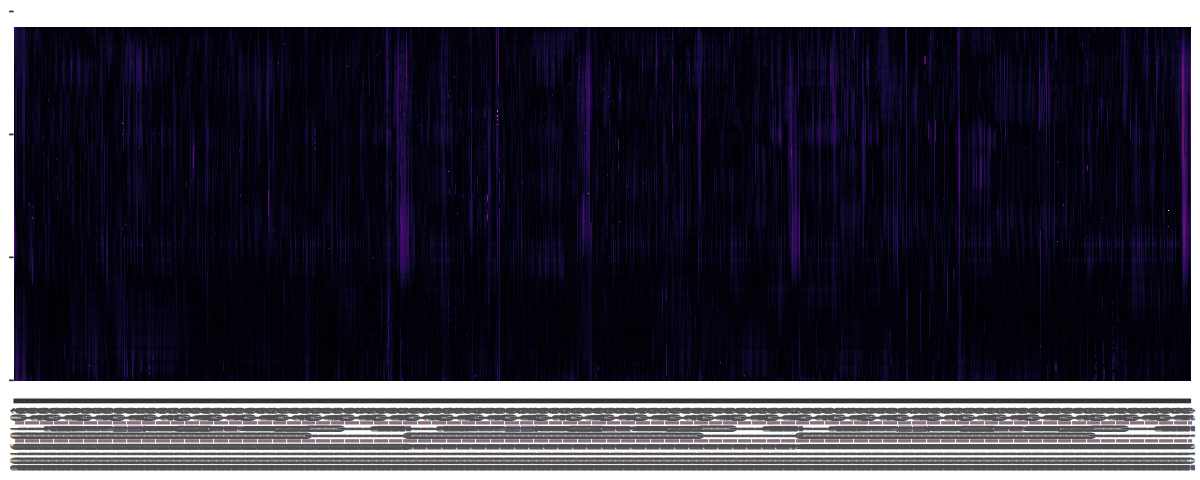

In [113]:
options(repr.plot.width=10, repr.plot.height=4)
x <- internet.daily[, c("date", "msm")]
x$val <- abs(internet.daily$bw - internet.daily$model)
#x$val <- ifelse(x$val > 35, x$val, 1)
ts_heatmap(x, col.scheme = "inferno")